<div style="text-align: center;">
  <h1>ML Project Group 36 - ELAD AND ETAY</h1>
</div>

# Table of Contents

- [Part 1](#Part-1)
  - [Catagoriel features distribution plot:](#Catagoriel-features-distribution-plot:)
  - [Numerical features distribution plot:](#Numerical-features-distribution-plot:)
  - [Dealing with categorical Feature:](#Dealing-with-categorical-Feature:)
   
- [Part 2](#Part-2:)
  - [PCA dimensionality reduction technic:](#PCA-dimensionality-reduction-technic:)

- [Part 3](#Part-3:)
  - [Basic Models (untuned H-peremters)](#Basic-Models-(untuned-H-peremters))
  - [Setting Hyperparameter:](#Setting-Hyperparameter:)

- [Part 4](#Part-4:)

- [Part 5](#Part-5:)


Importing :

In [1]:
%pip install numpy pandas matplotlib seaborn scipy scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix
from typing import List, Dict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_auc_score, mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from tqdm import tqdm
from numpy import interp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif


In [3]:
# load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Part 1

## Exploration of the data set

In [4]:
train_data.head(5)

,ID,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,B,C,D,country,prev_salary,stack_experience,label
0,65168,T,young,No,developer,NaN,Male,No,13.0,-1.093080,1.0,aa,180.984266,NaN,67104.0,Bash/Shell;Java;JavaScript;PowerShell;Python;T...,1
1,38314,T,young,No,non-developer,other,Male,Yes,7.0,5.444533,7.0,rhz,180.677533,United States of America,101000.0,Bash/Shell;JavaScript;PowerShell;Python;Docker...,0
2,5209,T,old,No,developer,other,Male,Yes,25.0,1.727255,15.0,aa,177.746162,United States of America,70000.0,Bash/Shell;HTML/CSS;Java;JavaScript;PHP;SQL;Gi...,0
3,54165,T,young,NaN,developer,other,Male,No,10.0,17.804302,7.0,aa,176.952584,Spain,40956.0,C#;Dart;Delphi;Kotlin;SQL;VBA;Docker;Unity 3D;...,0
4,42213,T,young,No,developer,BA/BSc,Male,No,12.0,-8.679091,4.0,hr,179.393259,Canada,101509.0,Assembly;Bash/Shell;C++;PowerShell;Python;Rust,0


## Catagoriel features distribution plot: 

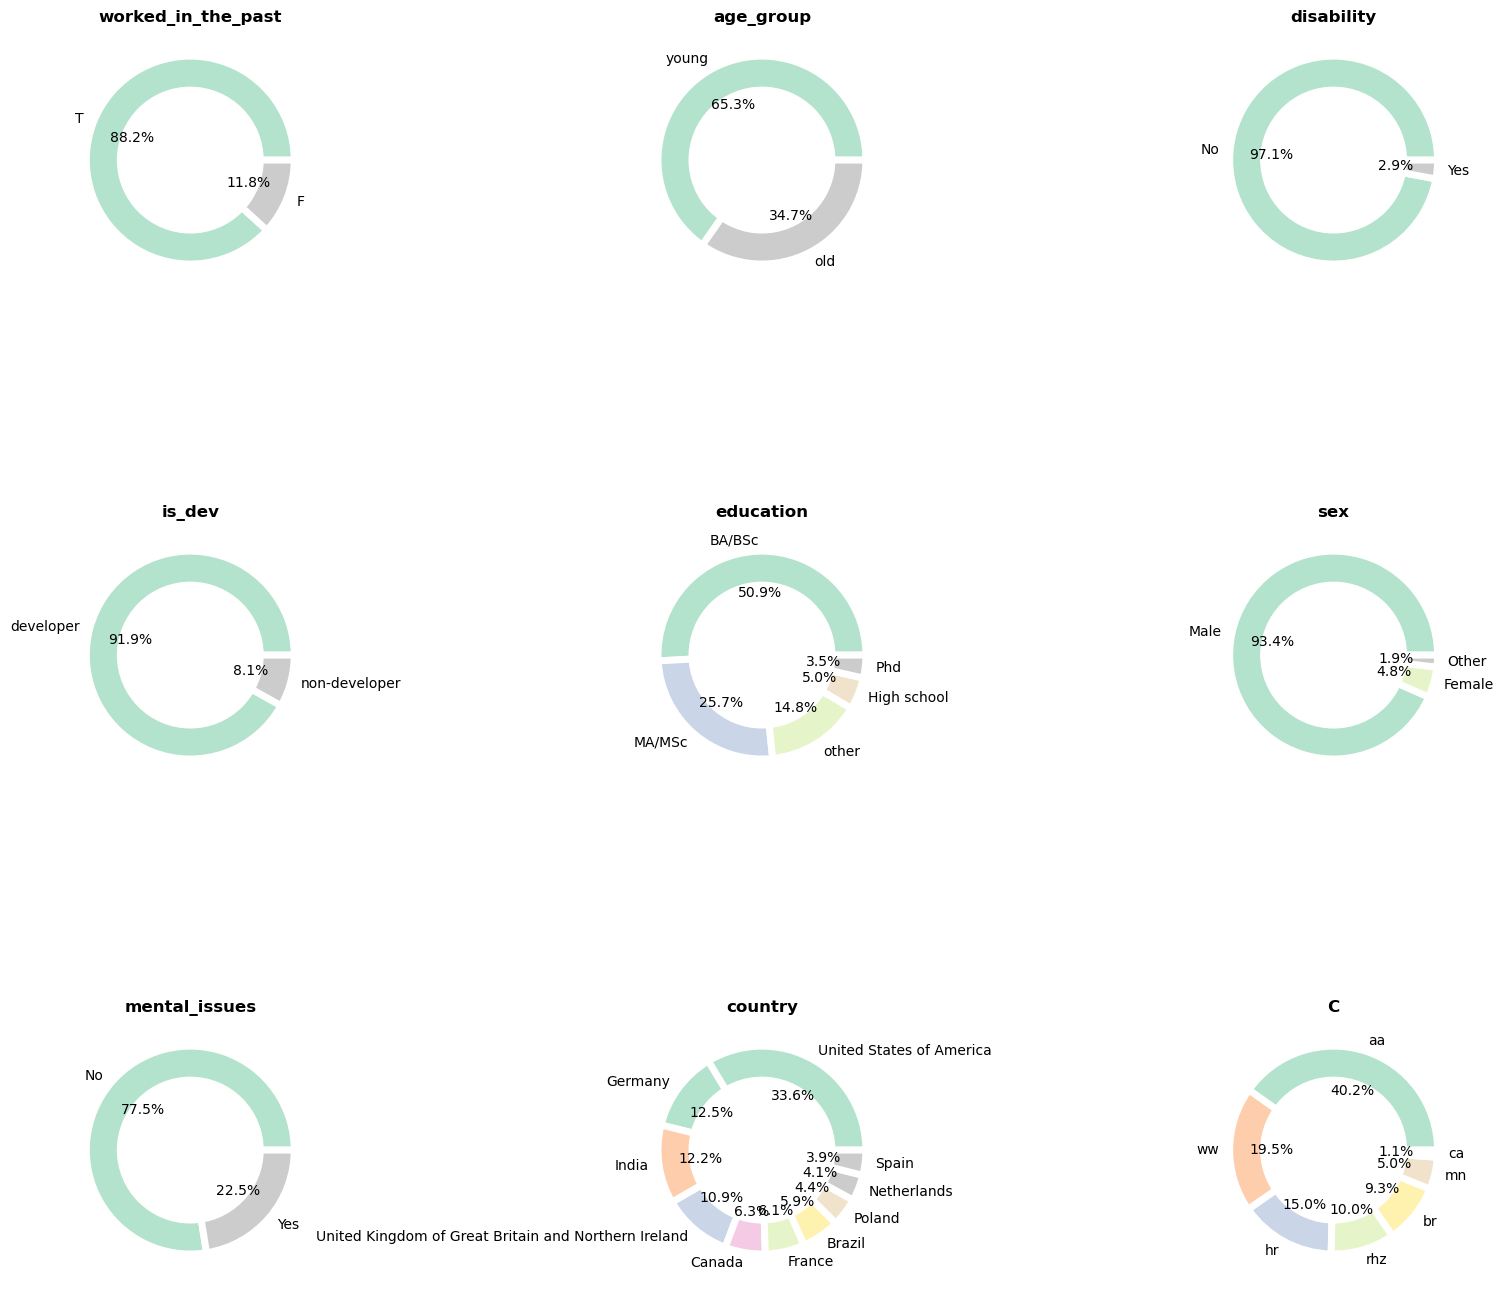

In [5]:
catagoriel_features = ['worked_in_the_past','age_group','disability','is_dev','education','sex','mental_issues','country','C']

def catagoriel_features_plot(fitch_name_list):
    n_features = len(fitch_name_list)
    n_cols = 3
    n_rows = (n_features // n_cols) + (n_features % n_cols > 0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    for idx, name in enumerate(fitch_name_list):
        size = train_data[name].value_counts().nlargest(10)
        cmap = plt.get_cmap("Pastel2")
        colors = cmap(np.linspace(0, 1, len(size)))
        my_circle = plt.Circle((0, 0), 0.7, color='white')
        labels = [f'{x:.2f}' if isinstance(x, float) else x for x in size.index]
        
        ax = axes[idx]
        ax.pie(size, colors=colors, labels=labels,
               wedgeprops={'linewidth': 5, 'edgecolor': 'white'},
               autopct="%.1f%%")
        ax.add_artist(my_circle)
        ax.set_title(name, weight='bold')
    for i in range(len(fitch_name_list), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

catagoriel_features_plot(catagoriel_features)

In [6]:
# finding number of missing values by features
print(train_data.isnull().sum())
print(f'train_data.shape before drop: {train_data.shape}')


ID                         0
worked_in_the_past      1765
age_group               2540
disability              3681
is_dev                  2090
education               3016
sex                     3228
mental_issues           2415
years_of_experience     2564
A                       2135
B                       3535
C                       3002
D                       2619
country                 2019
prev_salary             2664
stack_experience       14042
label                      0
dtype: int64
train_data.shape before drop: (55462, 17)


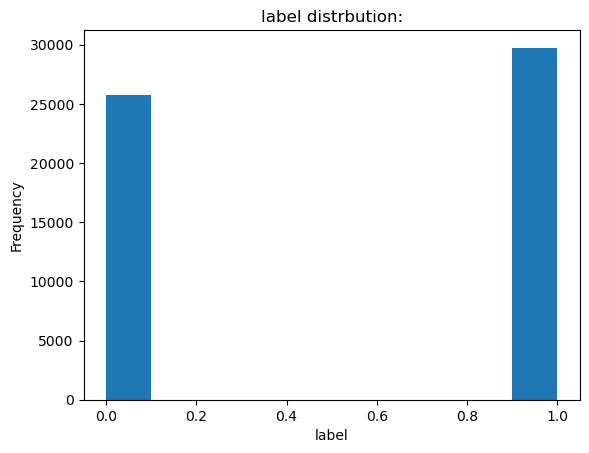

Model classifying only 0 will get auc :0.536 


In [7]:
#under sempling check :
train_data["label"].plot.hist()
plt.title("label distrbution:")
plt.xlabel("label")
plt.show()
print(f"Model classifying only 0 will get auc :{round(train_data['label'].sum() / train_data.shape[0],3)} ")

## Numerical features distribution plot: 

In [8]:
train_data[['A','B','D','years_of_experience','prev_salary']].describe()

,A,B,D,years_of_experience,prev_salary
count,53327.000000,51927.000000,52843.000000,52898.000000,52798.000000
mean,4.003959,9.079612,179.580295,14.214847,67800.074662
std,6.392311,7.965858,1.094272,9.391586,49583.999657
min,-21.637116,0.000000,175.077992,0.000000,1.000000
25%,-0.362863,3.000000,178.843985,7.000000,28800.000000
50%,3.606089,7.000000,179.584091,12.000000,57660.000000
75%,7.852744,12.000000,180.323694,20.000000,95979.000000
max,55.495063,50.000000,184.151007,50.000000,224000.000000


c:\Users\elad6\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


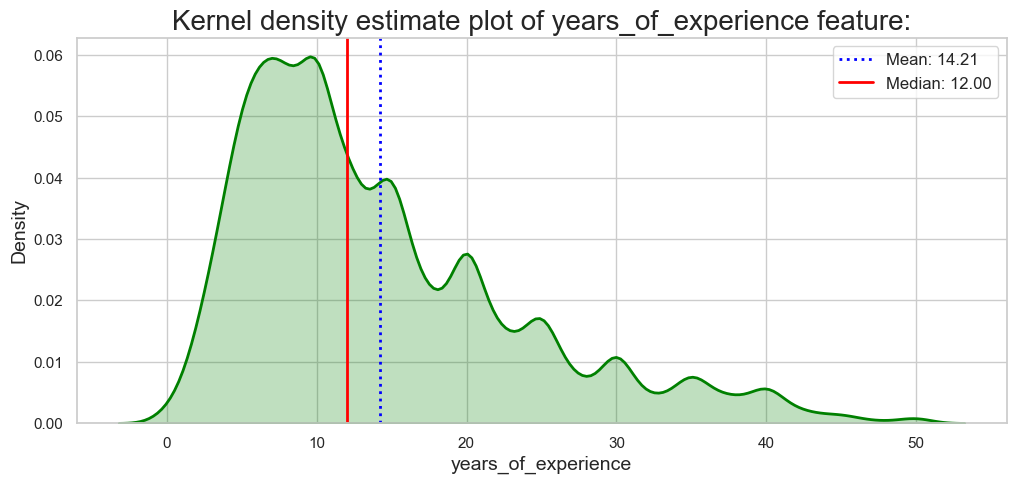

In [9]:
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

# KDE Plot with customizations
kde_plot = sns.kdeplot(train_data["years_of_experience"], fill=True, color="green", linewidth=2)

# Customize the plot
kde_plot.set_title('Kernel density estimate plot of years_of_experience feature:', fontsize=20)
kde_plot.set_xlabel('years_of_experience', fontsize=14)
kde_plot.set_ylabel('Density', fontsize=14)

# Add a vertical line for the mean
mean =train_data["years_of_experience"].mean()
plt.axvline(mean, color='blue', linestyle='dotted', linewidth=2, label=f'Mean: {mean:.2f}')

# Add a vertical line for the median
median = train_data["years_of_experience"].median()
plt.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')

# Add a legend
plt.legend(fontsize=12)

plt.show()

c:\Users\elad6\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\elad6\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


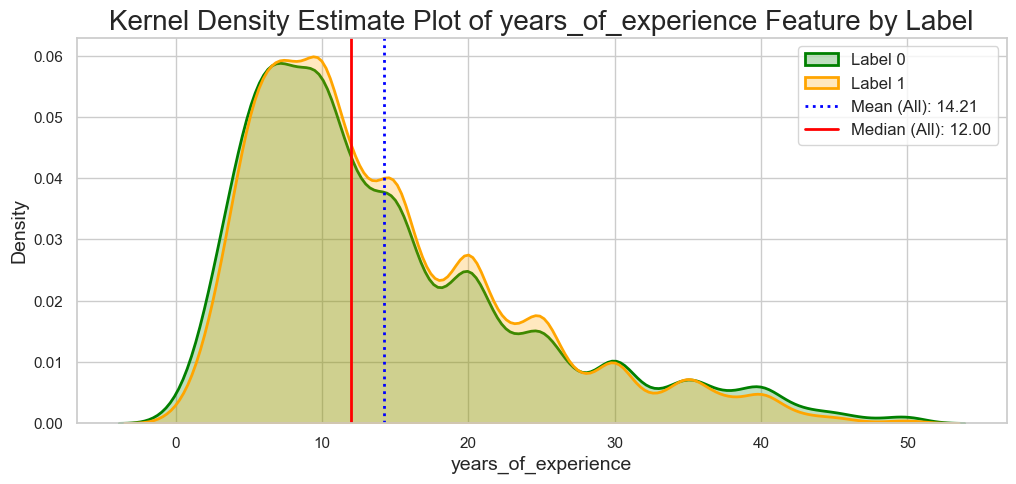

In [10]:

plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

# KDE Plot with customizations for label 0 and label 1
kde_plot_label_0 = sns.kdeplot(train_data[train_data['label'] == 0]["years_of_experience"], fill=True, color="green", linewidth=2, label='Label 0')
kde_plot_label_1 = sns.kdeplot(train_data[train_data['label'] == 1]["years_of_experience"], fill=True, color="orange", linewidth=2, label='Label 1')

# Customize the plot
plt.title('Kernel Density Estimate Plot of years_of_experience Feature by Label', fontsize=20)
plt.xlabel('years_of_experience', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add a vertical line for the mean of the entire dataset
mean = train_data["years_of_experience"].mean()
plt.axvline(mean, color='blue', linestyle='dotted', linewidth=2, label=f'Mean (All): {mean:.2f}')

# Add a vertical line for the median of the entire dataset
median = train_data["years_of_experience"].median()
plt.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median (All): {median:.2f}')

# Add a legend
plt.legend(fontsize=12)

plt.show()

c:\Users\elad6\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


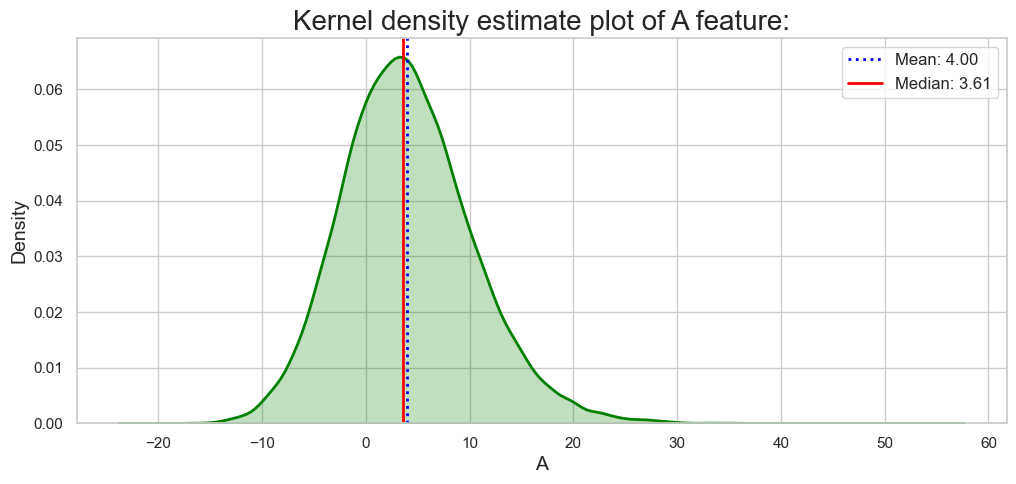

In [11]:
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

# KDE Plot with customizations
kde_plot = sns.kdeplot(train_data["A"], fill=True, color="green", linewidth=2)

# Customize the plot
kde_plot.set_title('Kernel density estimate plot of A feature:', fontsize=20)
kde_plot.set_xlabel('A', fontsize=14)
kde_plot.set_ylabel('Density', fontsize=14)

# Add a vertical line for the mean
mean =train_data["A"].mean()
plt.axvline(mean, color='blue', linestyle='dotted', linewidth=2, label=f'Mean: {mean:.2f}')

# Add a vertical line for the median
median = train_data["A"].median()
plt.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')

# Add a legend
plt.legend(fontsize=12)

plt.show()

c:\Users\elad6\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


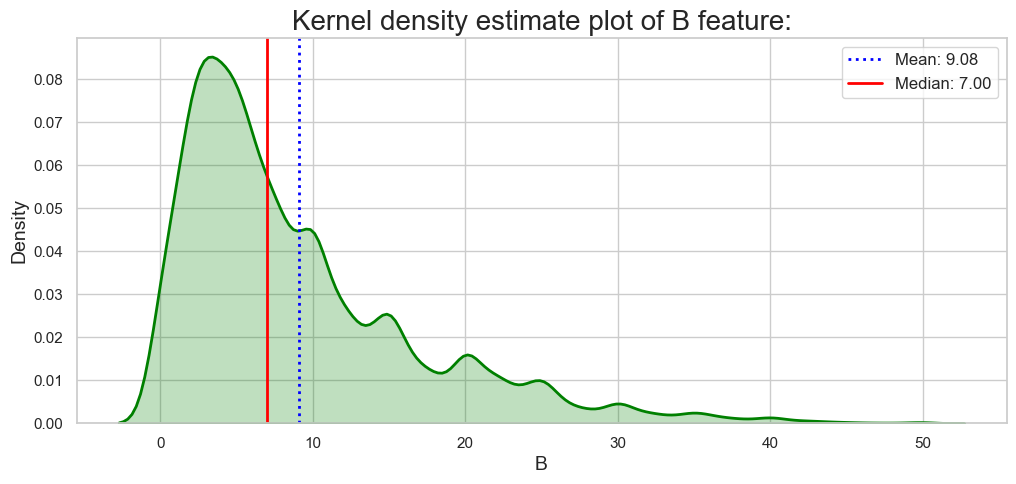

In [12]:
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

# KDE Plot with customizations
kde_plot = sns.kdeplot(train_data["B"], fill=True, color="green", linewidth=2)

# Customize the plot
kde_plot.set_title('Kernel density estimate plot of B feature:', fontsize=20)
kde_plot.set_xlabel('B', fontsize=14)
kde_plot.set_ylabel('Density', fontsize=14)

# Add a vertical line for the mean
mean =train_data["B"].mean()
plt.axvline(mean, color='blue', linestyle='dotted', linewidth=2, label=f'Mean: {mean:.2f}')

# Add a vertical line for the median
median = train_data["B"].median()
plt.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')

# Add a legend
plt.legend(fontsize=12)

plt.show()

c:\Users\elad6\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


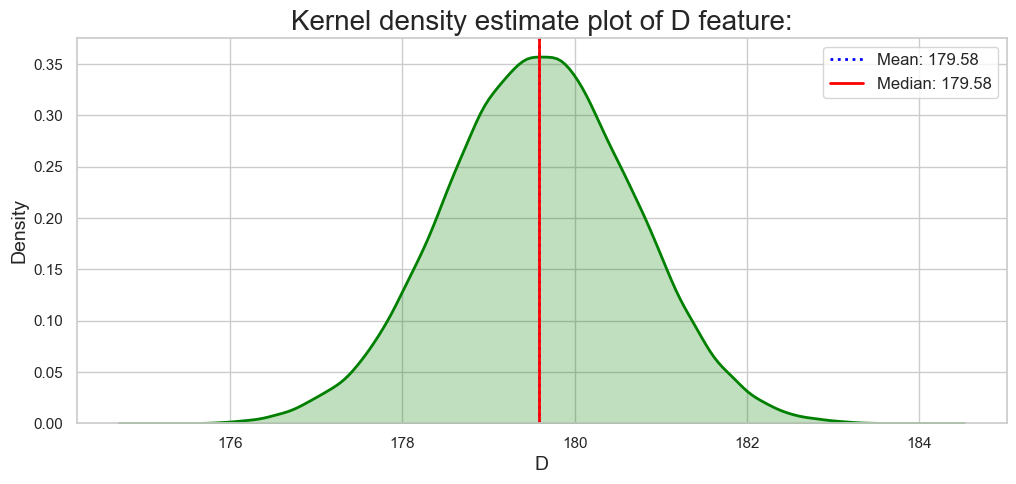

In [13]:
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

# KDE Plot with customizations
kde_plot = sns.kdeplot(train_data["D"], fill=True, color="green", linewidth=2)

# Customize the plot
kde_plot.set_title('Kernel density estimate plot of D feature:', fontsize=20)
kde_plot.set_xlabel('D', fontsize=14)
kde_plot.set_ylabel('Density', fontsize=14)

# Add a vertical line for the mean
mean =train_data["D"].mean()
plt.axvline(mean, color='blue', linestyle='dotted', linewidth=2, label=f'Mean: {mean:.2f}')

# Add a vertical line for the median
median = train_data["D"].median()
plt.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')

# Add a legend
plt.legend(fontsize=12)

plt.show()

c:\Users\elad6\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


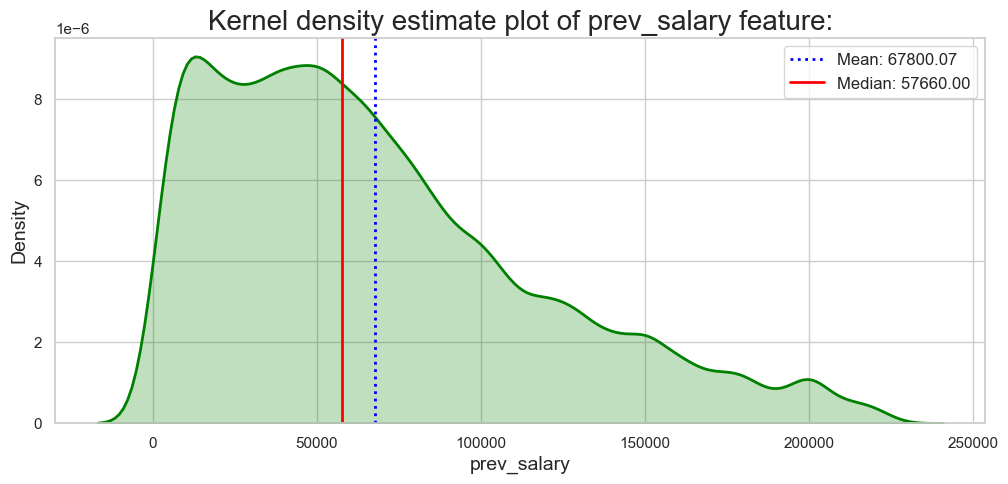

In [14]:
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

# KDE Plot with customizations
kde_plot = sns.kdeplot(train_data["prev_salary"], fill=True, color="green", linewidth=2)

# Customize the plot
kde_plot.set_title('Kernel density estimate plot of prev_salary feature:', fontsize=20)
kde_plot.set_xlabel('prev_salary', fontsize=14)
kde_plot.set_ylabel('Density', fontsize=14)

# Add a vertical line for the mean
mean =train_data["prev_salary"].mean()
plt.axvline(mean, color='blue', linestyle='dotted', linewidth=2, label=f'Mean: {mean:.2f}')

# Add a vertical line for the median
median = train_data["prev_salary"].median()
plt.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median: {median:.2f}')

# Add a legend
plt.legend(fontsize=12)

plt.show()

c:\Users\elad6\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\elad6\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


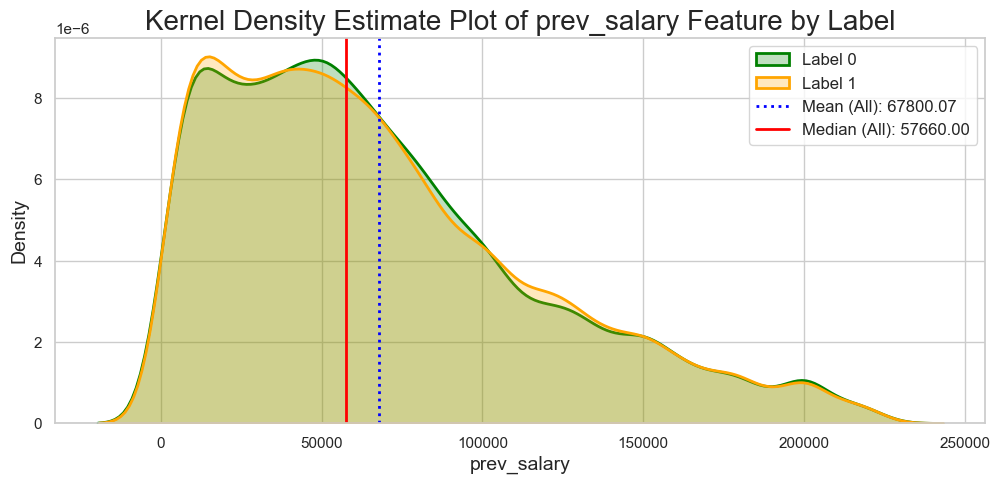

In [15]:

plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")

kde_plot_label_0 = sns.kdeplot(train_data[train_data['label'] == 0]["prev_salary"], fill=True, color="green", linewidth=2, label='Label 0')
kde_plot_label_1 = sns.kdeplot(train_data[train_data['label'] == 1]["prev_salary"], fill=True, color="orange", linewidth=2, label='Label 1')
plt.title('Kernel Density Estimate Plot of prev_salary Feature by Label', fontsize=20)
plt.xlabel('prev_salary', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Add a vertical line for the mean of the entire dataset
mean = train_data["prev_salary"].mean()
plt.axvline(mean, color='blue', linestyle='dotted', linewidth=2, label=f'Mean (All): {mean:.2f}')
# Add a vertical line for the median of the entire dataset
median = train_data["prev_salary"].median()
plt.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median (All): {median:.2f}')
plt.legend(fontsize=12)
plt.show()

In [16]:
def to_numery(train_data):
  #replacing the catagorial values to numerical
  train_data["age_group"]=train_data["age_group"].replace({"young":0,"old":1})
  train_data["disability"] = train_data["disability"].replace({"No":0,"Yes":1})
  train_data["is_dev"]=train_data["is_dev"].replace({"developer":0,"non-developer":1})
  train_data["mental_issues"]=train_data["mental_issues"].replace({"Yes":0,"No":1})
  train_data["worked_in_the_past"]=train_data["worked_in_the_past"].replace({"T":0,"F":1})

  count_options_per_clm_ed = train_data['education'].value_counts()
  for i in range(len(count_options_per_clm_ed)):
    train_data["education"]=train_data["education"].replace({count_options_per_clm_ed.index[i]:i})
  count_options_per_clm = train_data['C'].value_counts()
  for i in range(len(count_options_per_clm)):
    train_data["C"]=train_data["C"].replace({count_options_per_clm.index[i]:i})
  count_options_per_clm = train_data['sex'].value_counts()
  for i in range(len(count_options_per_clm)):
    train_data["sex"].replace({count_options_per_clm.index[i]:i},inplace=True)

  #transfering countries feature to continents.
  c_to_c = pd.read_csv("countryContinent.csv",encoding='ISO-8859-1')
  country_clm = train_data['country'].value_counts()
  continents_clm = c_to_c['continent'].value_counts()
  for i in range(len(continents_clm)):
    c_to_c["continent"]=c_to_c["continent"].replace({continents_clm.index[i]:i})
  country_to_continent = {}
  for country in country_clm.index:
      continent_row = c_to_c[c_to_c['country'] == country]
      if not continent_row.empty:
          continent_number = continent_row['continent'].iloc[0]
          country_to_continent[country] = continent_number
  train_data['country'] = train_data['country'].map(country_to_continent)
  return train_data
train_data= to_numery(train_data)

## Dealing with categorical Feature:


 1. as we described in the first part, in these feature which are divided into two groups, we replaced them to a binary classifcation. without any importance as to who got 0 and who got 1 because there is no meaning because there are two groups.
2. For the features that we saw in the first part that have more then 2 groups, we converted the categorical group to a numerical number in order to continue to apply a function of targt encoding.
3. For the countries features- we saw that there are many groups, so we chose to replace the countries values into groups of continents, we used an external file that defines which country is on which continent, and we gave each continent a number.
Later on we applied the  targt encoding function to it because it has a different meaning if you from continent more frequently or less frequently.

In [17]:
# Our first Try to encode the stack experience column: 
'''
web_dev = ['HTML/CSS', 'JavaScript', 'TypeScript', 'React.js', 'Vue.js', 'Angular', 'Angular.js', 'jQuery', 'Next.js', 'Gatsby', 'Svelte', 'Node.js', 'Express', 'PHP', 'ASP.NET Core ', 'ASP.NET', 'Django', 'Flask', 'Ruby on Rails', 'Spring', 'Laravel', 'FastAPI', 'Symfony', 'Phoenix', 'Play Framework']
programming_languages = ['Python', 'Java', 'C#', 'C++', 'C', 'Go', 'Rust', 'Ruby', 'Kotlin', 'Swift', 'Dart', 'R', 'Perl', 'Groovy', 'Scala', 'Objective-C', 'Delphi', 'Elixir', 'Haskell', 'Lua', 'Julia', 'F#', 'Deno', 'LISP', 'Flow', 'Erlang', 'Crystal', 'OCaml', 'Fortran', 'COBOL', 'APL']
databases = ['SQL', 'PostgreSQL', 'MySQL', 'Microsoft SQL Server', 'SQLite', 'MariaDB', 'Oracle', 'IBM DB2', 'MongoDB', 'Redis', 'DynamoDB', 'Cassandra', 'Couchbase', 'CouchDB', 'Neo4j', 'Elasticsearch', 'Firebase Realtime Database', 'Cloud Firestore']
cloud_devops = ['AWS', 'Microsoft Azure', 'Google Cloud Platform', 'Heroku', 'DigitalOcean', 'IBM Cloud or Watson', 'Oracle Cloud Infrastructure', 'VMware', 'Linode', 'OVH', 'Docker', 'Kubernetes', 'Terraform', 'Ansible', 'Puppet', 'Chef', 'Pulumi', 'OpenStack']
version_control = ['Git']
mobile_dev = ['Xamarin', 'Unity 3D', 'Unreal Engine']
scripting_automation = ['Bash/Shell', 'PowerShell', 'VBA', 'MATLAB', 'SAS']
frameworks_libraries = ['Spring', 'Ruby on Rails', 'Django', 'Flask', 'Laravel', 'Symfony', 'FastAPI', 'Phoenix', 'Play Framework', 'ASP.NET', 'ASP.NET Core', 'Blazor', 'Nuxt.js']
specialized_tools = ['Solidity', 'Rust', 'Crystal', 'Fortran', 'COBOL', 'APL']
game_dev = ['Unity 3D', 'Unreal Engine']
other_tools_services = ['Firebase', 'Managed Hosting', 'Colocation']


def count_skill_occurrences(skill_list, skills):
    return sum(skills.count(skill) for skill in skill_list)

def stack_encode(data):
    Skills=data['stack_experience'].str.split(';').explode().value_counts()
#change the coulm to list and fill the null to space
    data['stack_experience']=data['stack_experience'].str.split(';')
    data['stack_experience'] = data['stack_experience'].fillna('')
# check row by row if the skill of the person in the grop of coulm
    for group_name, group_skills in {
        'Web Development': web_dev,
        'Programming Languages': programming_languages,
        'Databases': databases,
        'Cloud & DevOps': cloud_devops,
        'Version Control & Package Managers': version_control,
        'Mobile Development': mobile_dev,
        'Scripting & Automation': scripting_automation,
        'Frameworks & Libraries': frameworks_libraries,
        'Specialized Tools': specialized_tools,
        'Game Development': game_dev,
        'Other Tools & Services': other_tools_services
        }.items():
            data[group_name] = data['stack_experience'].apply(lambda skills: count_skill_occurrences(group_skills, skills))
    
    return data.drop('stack_experience',axis=1)

train_data= stack_encode(train_data)
train_data.head(5)
'''

"\nweb_dev = ['HTML/CSS', 'JavaScript', 'TypeScript', 'React.js', 'Vue.js', 'Angular', 'Angular.js', 'jQuery', 'Next.js', 'Gatsby', 'Svelte', 'Node.js', 'Express', 'PHP', 'ASP.NET Core ', 'ASP.NET', 'Django', 'Flask', 'Ruby on Rails', 'Spring', 'Laravel', 'FastAPI', 'Symfony', 'Phoenix', 'Play Framework']\nprogramming_languages = ['Python', 'Java', 'C#', 'C++', 'C', 'Go', 'Rust', 'Ruby', 'Kotlin', 'Swift', 'Dart', 'R', 'Perl', 'Groovy', 'Scala', 'Objective-C', 'Delphi', 'Elixir', 'Haskell', 'Lua', 'Julia', 'F#', 'Deno', 'LISP', 'Flow', 'Erlang', 'Crystal', 'OCaml', 'Fortran', 'COBOL', 'APL']\ndatabases = ['SQL', 'PostgreSQL', 'MySQL', 'Microsoft SQL Server', 'SQLite', 'MariaDB', 'Oracle', 'IBM DB2', 'MongoDB', 'Redis', 'DynamoDB', 'Cassandra', 'Couchbase', 'CouchDB', 'Neo4j', 'Elasticsearch', 'Firebase Realtime Database', 'Cloud Firestore']\ncloud_devops = ['AWS', 'Microsoft Azure', 'Google Cloud Platform', 'Heroku', 'DigitalOcean', 'IBM Cloud or Watson', 'Oracle Cloud Infrastructure',

In [18]:
#Our final solution in order to encode the stack exp. column by 
#using Tfidf method

tfidf_vectorize=TfidfVectorizer()
corpus = train_data['stack_experience'].fillna('')
tfidf_vectorizer_vectors=tfidf_vectorize.fit_transform(corpus)
dense_vectors = tfidf_vectorizer_vectors.todense()

# normalize the vectors to have unit norm.
stack_exp_tfidf_data = pd.DataFrame(dense_vectors, columns=tfidf_vectorize.get_feature_names_out())

# Calculate Mutual Information
mi = mutual_info_classif(stack_exp_tfidf_data, train_data['label'])

# Create a DataFrame with feature names and their MI scores
features = tfidf_vectorize.get_feature_names_out()
mi_df = pd.DataFrame({'feature': features, 'mi_score': mi})

# Sort the DataFrame by MI scores and select top 20 features
top_features = mi_df.sort_values(by='mi_score', ascending=False).head(20)

stack_exp_tfidf_data = stack_exp_tfidf_data[top_features['feature'].to_list()]
train_data = pd.concat([train_data,stack_exp_tfidf_data],axis=1)
train_data =  train_data.drop('stack_experience',axis=1)
train_data.head(5)


,ID,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,...,mongodb,js,mysql,java,npm,aws,sql,react,sqlite,bash
0,65168,0.0,0.0,0.0,0.0,NaN,0.0,1.0,13.0,-1.093080,...,0.0,0.374990,0.000000,0.247028,0.275242,0.213167,0.000000,0.00000,0.0,0.250437
1,38314,0.0,0.0,0.0,1.0,2.0,0.0,0.0,7.0,5.444533,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.348897
2,5209,0.0,1.0,0.0,0.0,2.0,0.0,0.0,25.0,1.727255,...,0.0,0.194885,0.228108,0.256765,0.000000,0.000000,0.189860,0.24732,0.0,0.260308
3,54165,0.0,0.0,NaN,0.0,2.0,0.0,1.0,10.0,17.804302,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.171903,0.00000,0.0,0.000000
4,42213,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,-8.679091,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.306264


In [19]:
# pipeline function using tfidf method 
def stack_encode(data):
    corpus = data['stack_experience'].fillna('')
    tfidf_vectorizer_vectors=tfidf_vectorize.fit_transform(corpus)
    dense_vectors = tfidf_vectorizer_vectors.todense()
    
    # normalize the vectors to have unit norm.
    stack_exp_tfidf_data = pd.DataFrame(dense_vectors, columns=tfidf_vectorize.get_feature_names_out())
    '''
    # Calculate Mutual Information
    mi = mutual_info_classif(stack_exp_tfidf_data, data['label'])

    # Create a DataFrame with feature names and their MI scores
    features = tfidf_vectorize.get_feature_names_out()
    mi_df = pd.DataFrame({'feature': features, 'mi_score': mi})

    # Sort the DataFrame by MI scores and select top 20 features
    top_features = mi_df.sort_values(by='mi_score', ascending=False).head(20)
    '''
    stack_exp_tfidf_data = stack_exp_tfidf_data[top_features['feature'].to_list()]
    data = pd.concat([data,stack_exp_tfidf_data],axis=1)
    return data.drop('stack_experience',axis=1)


### For the stack experience feature:

In first sight we saw there are many skills and many types of skills (124). We decided at first to divide this feature into 11 different groups of features according to the types of skills and sum for each sample the amount of skills he has from each group.

With our first method we succeed to get 0.89 auc in MLP and RFC modles but did'nt succeed to overcome it. so we decided to try a different approach encodeing the column. By using tfidf method we got 124 features for every word showed in the column. we tried sevreal methods in order to find the most meaningful features (PCA,Kmeans).Evantually using Mutual Information measurement we took only the highest 20 features according to their score. 

the MI measure is a way to understand the dependency between each feature and our label column so we can find the most meaningful features in order to avoid adding too much features and getting under the dimensionality problem.

Although in this operation the dimensionality of the problem increased, it helped to improve the accuracy of the models. 

## Corrletion analysis:

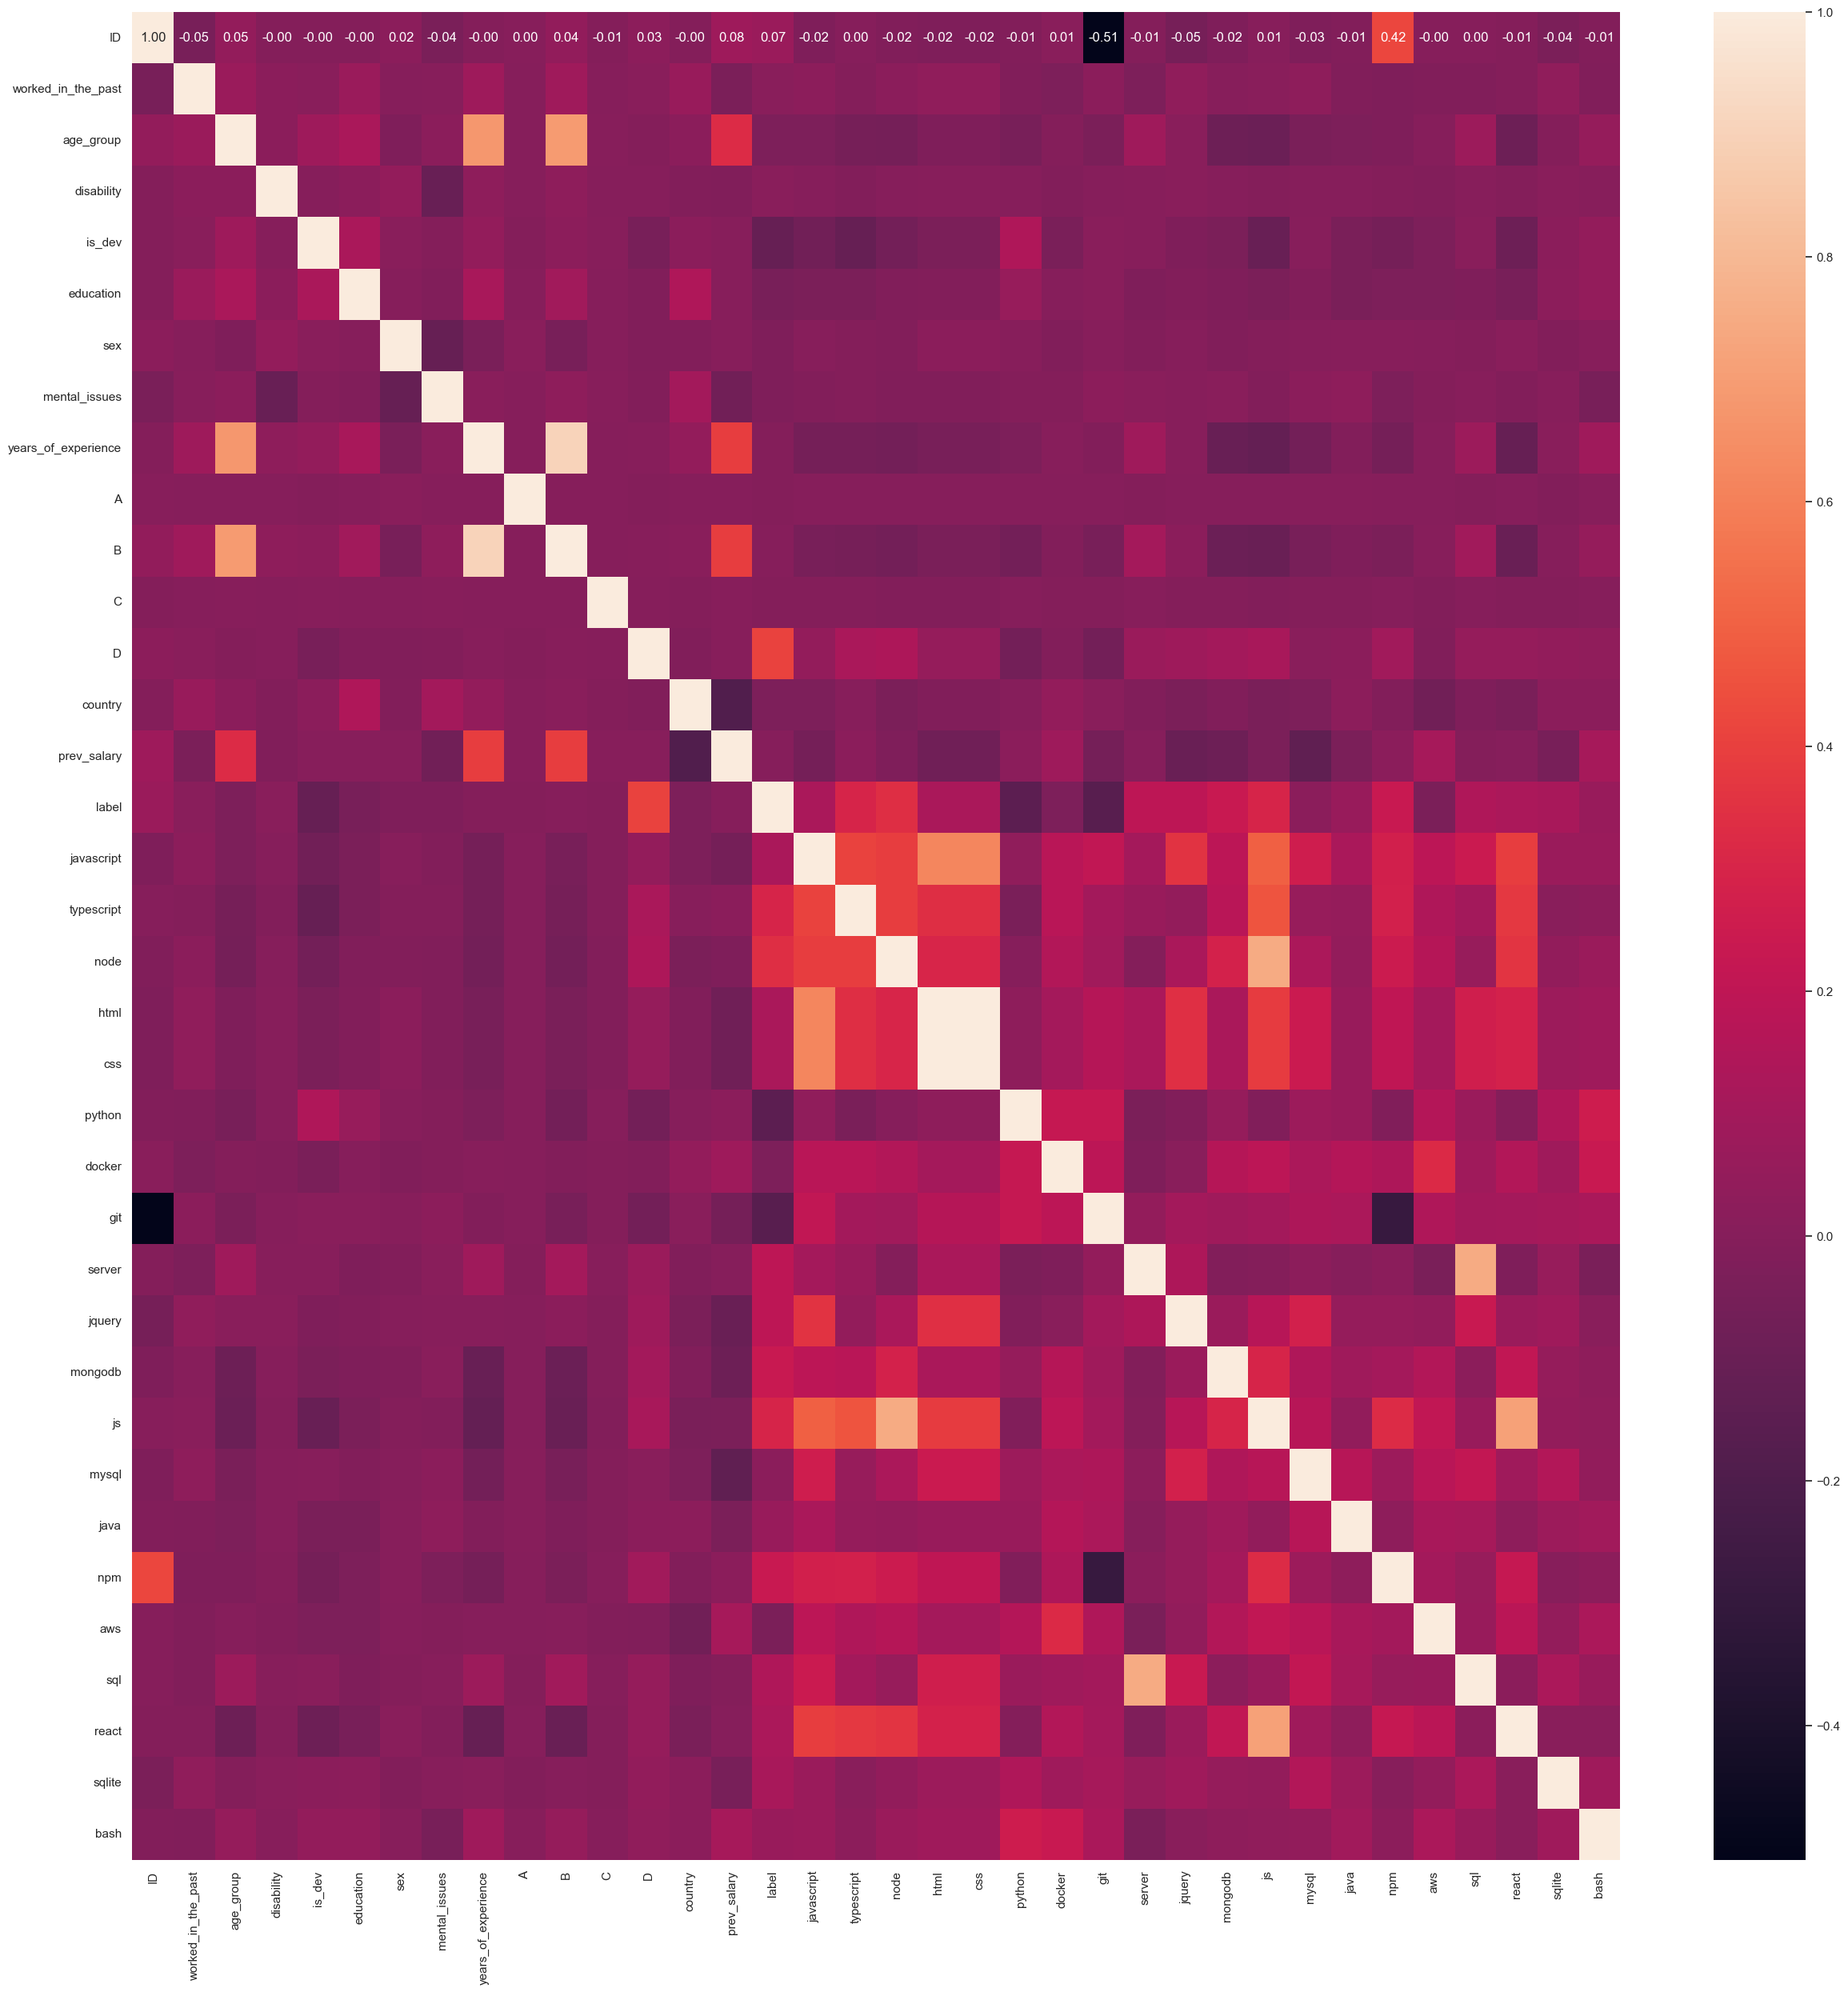

In [20]:
#making a corrletion heatmap
plt.figure(figsize=(30, 30))
cor_matrix = train_data.corr()
sns.heatmap(cor_matrix,annot=True,fmt=".2f")
plt.show()

In [21]:
#showing the high corrlated features and the corlletion values: 
cor_matrix = cor_matrix[cor_matrix>=0.75]
cor_matrix = cor_matrix.abs()
cor_matrix = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
cor_matrix

html                 css    1.000000
years_of_experience  B      0.900905
node                 js     0.751395
server               sql    0.750259
dtype: float64

In [22]:
#lable corrletion :
lbl_corr = train_data.corr()["label"]
lbl_corr.abs().sort_values(ascending=False)[1:]

D                      0.406377
node                   0.335262
typescript             0.297132
js                     0.293013
mongodb                0.237623
npm                    0.236501
server                 0.193680
jquery                 0.193171
git                    0.164854
python                 0.149399
sql                    0.141153
react                  0.129327
javascript             0.125895
html                   0.121464
css                    0.121464
sqlite                 0.120793
is_dev                 0.109356
ID                     0.069787
java                   0.066174
bash                   0.063338
education              0.047206
aws                    0.035484
country                0.030544
age_group              0.029010
docker                 0.027068
mental_issues          0.025132
sex                    0.024427
mysql                  0.019005
disability             0.012715
worked_in_the_past     0.011123
C                      0.004773
A       

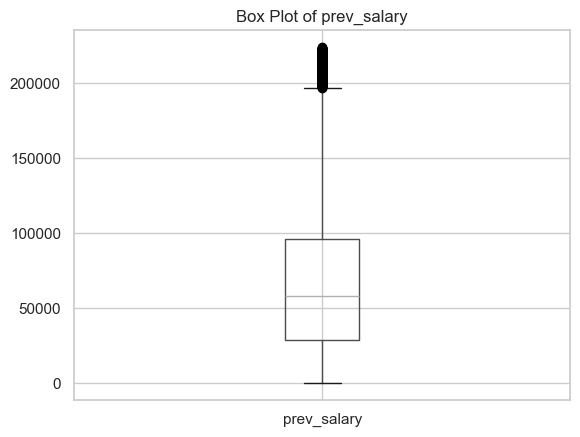

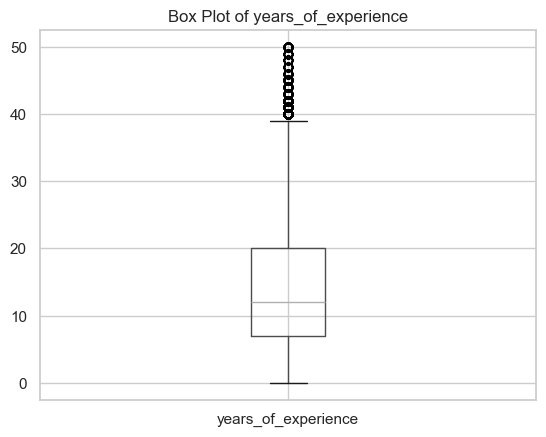

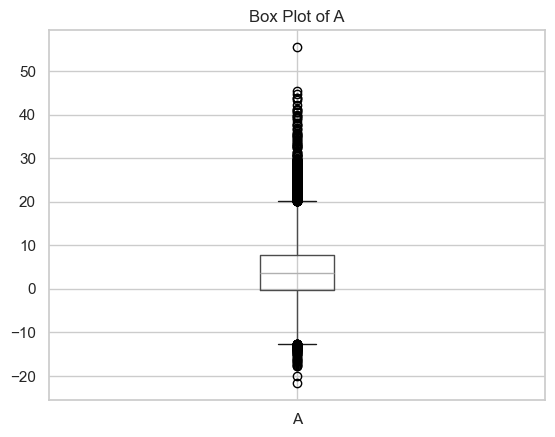

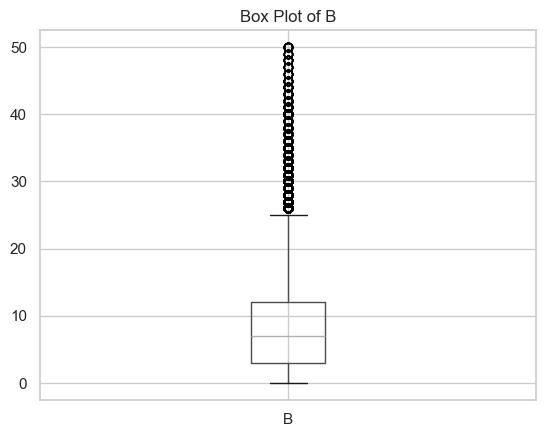

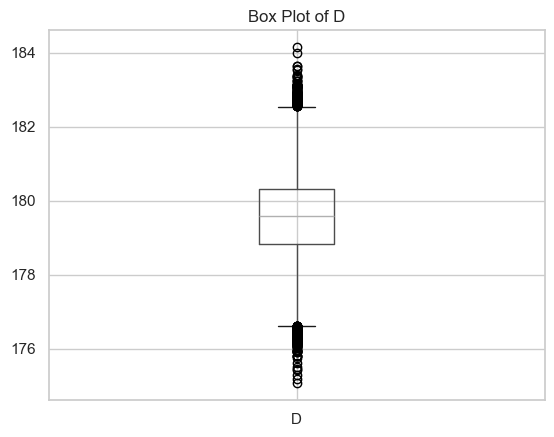

In [23]:
#outlier poltting
train_data.boxplot('prev_salary')
plt.title('Box Plot of prev_salary')
plt.show()

train_data.boxplot('years_of_experience')
plt.title('Box Plot of years_of_experience')
plt.show()

train_data.boxplot('A')
plt.title('Box Plot of A')
plt.show()

train_data.boxplot('B')
plt.title('Box Plot of B')
plt.show()

train_data.boxplot('D')
plt.title('Box Plot of D')
plt.show()

# Part 2 : 
## Preprocessing 

In [24]:
#split train to labels and data
train_data_labels = train_data['label']
train_data = train_data.drop('label',axis=1)

In [25]:
# droping id feature in train data 
ID_col_train_data = train_data['ID']
train_data = train_data.drop('ID',axis=1)
# print shape
print(f'train_data.shape: {train_data.shape}, test_data.shape: {test_data.shape}')


train_data.shape: (55462, 34), test_data.shape: (18000, 16)


In [26]:
# droping all the lines in train data that has 75% of missing values
def drop_null_row(data):
    print(f'train_data shape before drop: {data.shape}')
    tresh_hold = 0.3*(data.shape[1])
    data.dropna(thresh=tresh_hold, inplace=True)
    print(f'train_data shape after drop: {data.shape}')
    return data
train_data= drop_null_row(train_data)


train_data shape before drop: (55462, 34)
train_data shape after drop: (55462, 34)


## Dealing with missing values: 
 We actively decided that lines of code that have more than 0.4 percent of missing values we have no way to get use of them in the model training and everything will be filled by values ​​that we determined, so we decided in the first step to drop those samples.

 We chose 0.3 precent because we wanted to see if from the 15 lines we have without the 19 features we added from the stack experience(that are for sure without Nans). we wanted to see if there are 10 lines apporx. that are empty so we will elimnate them. 

In [27]:
def target_encode(X, y,weight,fitch_list):
    res_val_per_fitch =[]
    overall_mean = y.mean()
    for f in fitch_list:
        group_mean_val = y.groupby(X[f]).mean()
        group_counts = X[f].value_counts()
        res_val = (group_mean_val*group_counts + overall_mean*weight)/(group_counts+weight)
        X[f] = X[f].map(res_val)
        res_val_per_fitch.append ([res_val])
    return X,res_val_per_fitch


fit_list = ['C','education','sex','country']
train_data,res_val_per_fitch = target_encode(train_data, train_data_labels,20,fit_list)
print(train_data.head(5))
%store res_val_per_fitch

   worked_in_the_past  age_group  disability  is_dev  education       sex  \
0                 0.0        0.0         0.0     0.0        NaN  0.540909   
1                 0.0        0.0         0.0     1.0   0.583737  0.540909   
2                 0.0        1.0         0.0     0.0   0.583737  0.540909   
3                 0.0        0.0         NaN     0.0   0.583737  0.540909   
4                 0.0        0.0         0.0     0.0   0.558744  0.540909   

   mental_issues  years_of_experience          A     B  ...  mongodb  \
0            1.0                 13.0  -1.093080   1.0  ...      0.0   
1            0.0                  7.0   5.444533   7.0  ...      0.0   
2            0.0                 25.0   1.727255  15.0  ...      0.0   
3            1.0                 10.0  17.804302   7.0  ...      0.0   
4            1.0                 12.0  -8.679091   4.0  ...      0.0   

         js     mysql      java       npm       aws       sql    react  \
0  0.374990  0.000000  0.24702

Explantion to target endoing method and our using of it in part 6 in the final report.

In [28]:
#dropping features according to corrletion map
def drop_col(train_data):
    train_data = train_data.drop('B',axis=1)
    train_data = train_data.drop('css',axis=1)
    return train_data
train_data= drop_col(train_data)

### Dimenssionality Reduction actions: 

After we saw in part 1 that there is a high correlation between these values, we chose to reduce the dimensionality in a pro-active manner and to drop features ​​with a correlation equal or higher than 0.9

In [29]:

def null_fill(train_data):
    train_data['worked_in_the_past']=train_data['worked_in_the_past'].fillna(train_data['worked_in_the_past'].mode()[0])

    train_data['age_group']=train_data['age_group'].fillna('0.0')

    train_data['disability']=train_data['disability'].fillna('0.0')

    train_data['is_dev']=train_data['is_dev'].fillna(train_data['is_dev'].mode()[0])

    train_data['education']=train_data['education'].fillna(train_data['education'].mode()[0])
    train_data['education'] = train_data.education.astype(float)

    train_data['sex']=train_data['sex'].fillna('0.0')
    train_data['sex'] = train_data.sex.astype(float)

    train_data['mental_issues']=train_data['mental_issues'].fillna(train_data['mental_issues'].mode()[0])
    train_data['years_of_experience']=train_data['years_of_experience'].fillna(train_data['years_of_experience'].median())
    train_data['A']=train_data['A'].fillna(train_data['A'].median())
    train_data['C']=train_data['C'].fillna(train_data['C'].mode()[0])
    train_data['D']=train_data['D'].fillna(train_data['D'].mean())
    train_data['country']=train_data['country'].fillna(train_data['country'].mode()[0])
    train_data['prev_salary']=train_data['prev_salary'].fillna(train_data['prev_salary'].median())
    index = (((train_data.iloc[:, 13:] == 0).all(axis=1)) & (train_data['is_dev']==1))
    for i in range(13,train_data.shape[1]):
        mean_to_fill =train_data.iloc[:,i].mean()
        train_data.loc[index, train_data.columns[i]] = train_data.loc[index, train_data.columns[i]].replace(0,mean_to_fill)
    return train_data

train_data= null_fill(train_data)
print(train_data.isnull().sum())

worked_in_the_past     0
age_group              0
disability             0
is_dev                 0
education              0
sex                    0
mental_issues          0
years_of_experience    0
A                      0
C                      0
D                      0
country                0
prev_salary            0
javascript             0
typescript             0
node                   0
html                   0
python                 0
docker                 0
git                    0
server                 0
jquery                 0
mongodb                0
js                     0
mysql                  0
java                   0
npm                    0
aws                    0
sql                    0
react                  0
sqlite                 0
bash                   0
dtype: int64


Dealing with missing values- we examined some missing values, and filled them according to the definitions we explained in part 1 of the summary report.

In [30]:
#normalizing the data

def normalize_data(data):
  #min-max scalling
  data["years_of_experience"] = (data["years_of_experience"] - data["years_of_experience"].min()) / (data["years_of_experience"].max() - data["years_of_experience"].min())
  data["prev_salary"] = (data["prev_salary"] - data["prev_salary"].min()) / (data["prev_salary"].max() - data["prev_salary"].min())
  #standart scalling
  scaler = StandardScaler()
  data[["A","D"]] = scaler.fit_transform(data[["A","D"]])
  return data

train_data_norm = normalize_data(train_data)
train_data_norm.head(5)

,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,C,...,mongodb,js,mysql,java,npm,aws,sql,react,sqlite,bash
0,0.0,0.0,0.0,0.0,0.558744,0.540909,1.0,0.26,-0.810679,0.541215,...,0.0,0.374990,0.000000,0.247028,0.275242,0.213167,0.000000,0.00000,0.0,0.250437
1,0.0,0.0,0.0,1.0,0.583737,0.540909,0.0,0.14,0.232256,0.528462,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.348897
2,0.0,1.0,0.0,0.0,0.583737,0.540909,0.0,0.50,-0.360756,0.541215,...,0.0,0.194885,0.228108,0.256765,0.000000,0.000000,0.189860,0.24732,0.0,0.260308
3,0.0,0.0,0.0,0.0,0.583737,0.540909,1.0,0.20,2.203990,0.541215,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.171903,0.00000,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.558744,0.540909,1.0,0.24,-2.020863,0.526394,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.306264


### normalizing : 
The features we are dealing with here are not normalize and contain numerical values. 

In the first part we dealed with the catagoriel features so they are already normalized between 0-1.

At this stage, features that we presented in the summary report as being normally distributed we decided to normalize by StandardScaler,
while features that are'nt normally distributed we decided to normalize by using max-min method, as we concluded from the report in the first part.

We decided to normalize the data for the use of linear models which we use later.

In [31]:
def fill_outliers_with_mean(data,feature_name):
  Q1 = data[feature_name].quantile(0.25)
  Q3 = data[feature_name].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  mean_value = data[feature_name].mean()

  data[feature_name] = np.where((data[feature_name] < lower_bound) | (data[feature_name] > upper_bound), mean_value, data[feature_name])

In [32]:
def fill_outliers_with_median(data, column_name):
    z_scores = np.abs(stats.zscore(data[column_name]))
    median_value = data[column_name].median()

    data[column_name] = np.where(z_scores > 3, median_value, data[column_name])

In [33]:
#outlier removal from train data only

print("Original shape:", train_data_norm.shape)

# Fill outliers for normally distributed features with median
fill_outliers_with_median(train_data_norm, 'A')
fill_outliers_with_median(train_data_norm, 'D')

# Fill outliers for not normally distributed features with mean
fill_outliers_with_mean(train_data_norm, 'years_of_experience')
fill_outliers_with_mean(train_data_norm, 'prev_salary')

print("New shape:", train_data_norm.shape)

Original shape: (55462, 32)
New shape: (55462, 32)


### Outliers : 
As we described in the summary report in part 1, for variables that are normally distributed we chose to check whether the attribute is larger or smaller by 3 standard deviations. If so, we replaced them with the average value (expectancy) for variables that are not normally distributed, we used the IQR method(full explanation in the full report) we replaced the value with the median instead.

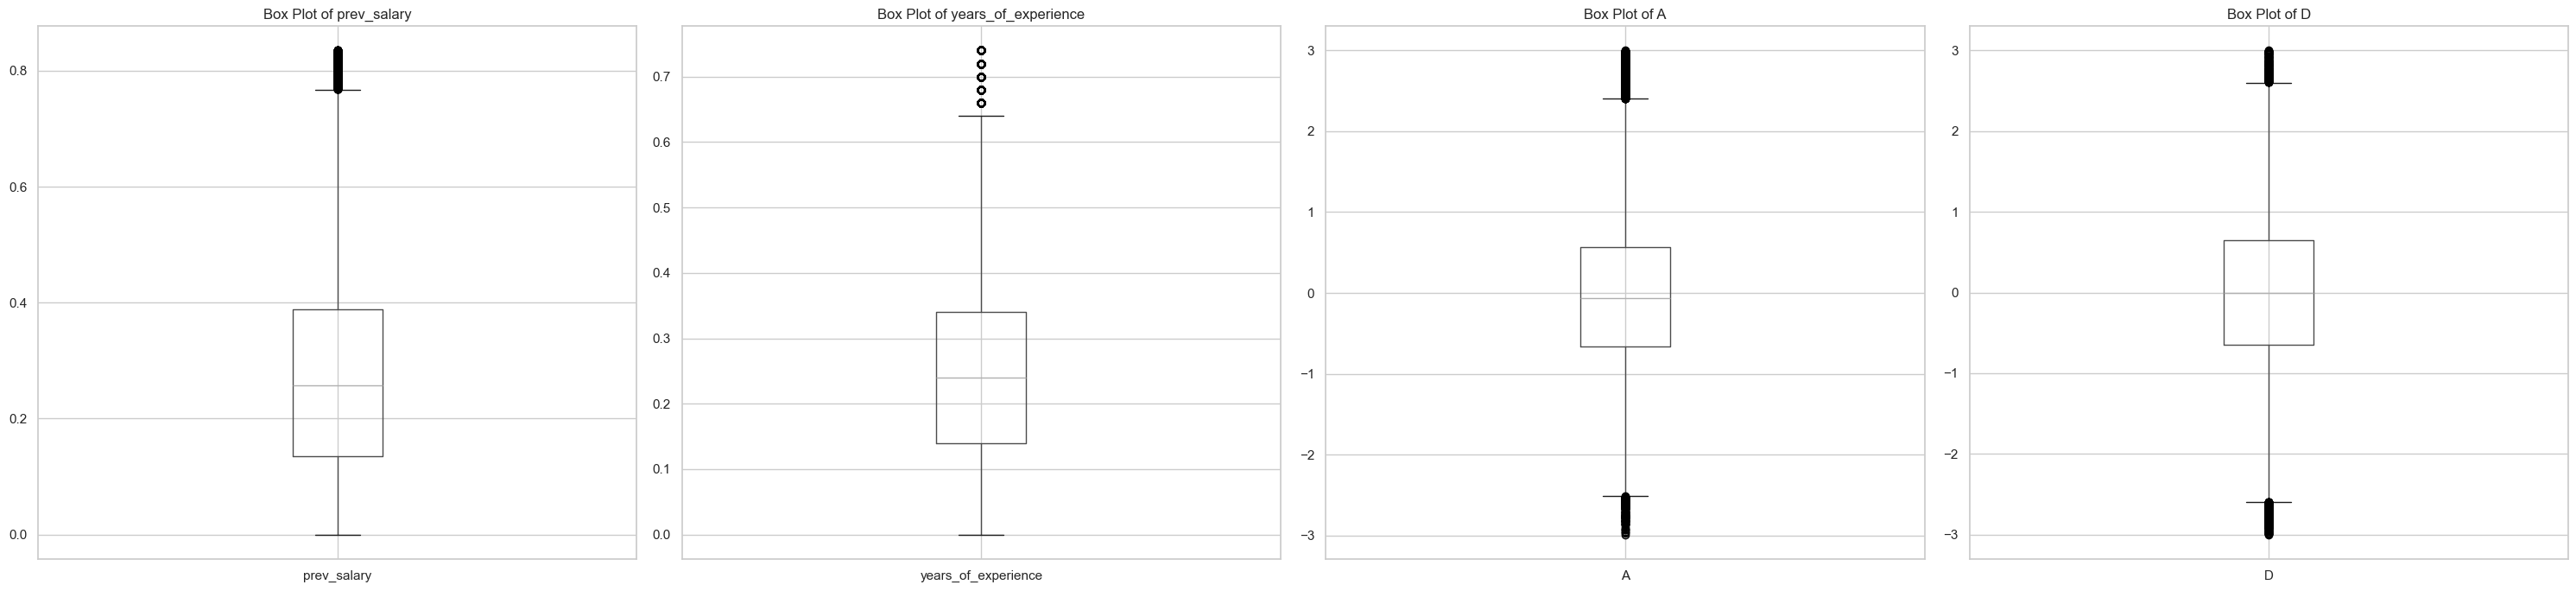

In [34]:

columns = ['prev_salary', 'years_of_experience', 'A', 'D']

fig, axes = plt.subplots(1, len(columns), figsize=(30, 7))

for ax, col in zip(axes, columns):
    train_data.boxplot(column=col, ax=ax)
    ax.set_title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

In [35]:
# spliting train to - train and validation

train_data_norm_full = train_data_norm.copy()
train_data_labels_norm_full = train_data_labels.copy()

train_data_norm,validation_data_norm ,train_data_labels_norm,validation_labels_norm = train_test_split(train_data_norm,train_data_labels,
                                                        test_size = 0.15,
                                                        random_state= 42,
                                                        shuffle=True)
# print shape
print(f'Train sets shapes:\ntrain_data_norm.shape: {train_data_norm.shape},\ntrain_data_labels_norm.shape: {train_data_labels_norm.shape},\n')
print(f'Validation sets shapes:\nvalidation_data_norm.shape: {validation_data_norm.shape},\nvalidation_labels_norm.shape: {validation_labels_norm.shape},\ntest_data.shape: {test_data.shape}')


Train sets shapes:
train_data_norm.shape: (47142, 32),
train_data_labels_norm.shape: (47142,),

Validation sets shapes:
validation_data_norm.shape: (8320, 32),
validation_labels_norm.shape: (8320,),
test_data.shape: (18000, 16)


In [36]:
#plotting the data after process: 
print(train_data_norm.shape)
print(train_data_norm.head(5))

(47142, 32)
       worked_in_the_past age_group disability  is_dev  education       sex  \
35070                 0.0       0.0        0.0     0.0   0.558744  0.540909   
41277                 0.0       0.0        0.0     0.0   0.558744  0.540909   
10520                 0.0       1.0        0.0     0.0   0.491439  0.540909   
16604                 1.0       1.0        0.0     1.0   0.583737  0.540909   
4455                  0.0       0.0        0.0     0.0   0.558744  0.540909   

       mental_issues  years_of_experience         A         C  ...   mongodb  \
35070            1.0                 0.28  0.735109  0.534805  ...  0.000000   
41277            0.0                 0.14  1.768901  0.541215  ...  0.000000   
10520            1.0                 0.36  1.792264  0.541215  ...  0.000000   
16604            0.0                 0.62 -0.593593  0.534805  ...  0.038352   
4455             1.0                 0.20  0.204987  0.541215  ...  0.000000   

             js     mysql      j

The dimensions of the problem can be diagnosed by several central phenomena:

1. The overfitting phenomenon of the model - meaning the auc result of our model on our training set will be very high and significantly higher compared to our auc result on the validation set.
2. Long running time and high calculation consumption - if we have a large data set that also has many features, we will see the calculation time of the model is very high and this can significantly limit us.
3. In the classification problem, we may see bad auc results that express the fact that the information is spread out in space in a scattered and not concentrated way, therefore it is very difficult for the model to find the unknown function after which we are seeking.

Large dimensionality can create a problem for all the reasons stated above. According to the examination of the model after the preprocess stage, we find ourselves with about 23 dimensions which, relative to the size of the problem, we estimate that we're not under the "curse of dimensionality". 

We would like to emphasize that by applying the method we decided to encode the stack_experience column we succeed to deacrese the dimensionality of the data set in edvance and didn't try one hot encoding method, for exemple how would put us in more than 50 featuers.

## PCA dimensionality reduction technic:

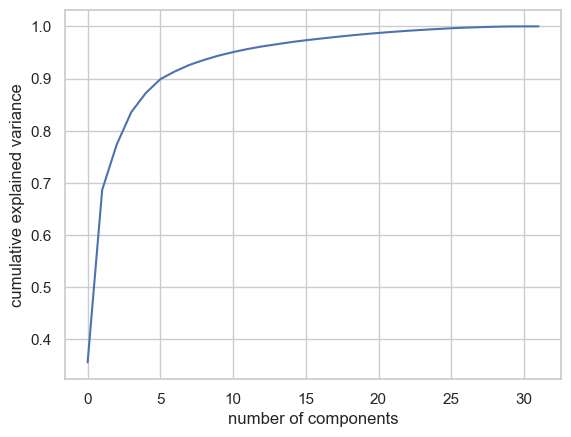

In [37]:
pca = PCA().fit(train_data_norm)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [38]:

pca=PCA(0.99)
train_data_norm_pca= pca.fit_transform(train_data_norm)
print("The number of dimenssion after PCA : ",train_data_norm_pca.shape[1])

The number of dimenssion after PCA :  23


After trying the train data set after using PCA we decided to not use the method because we got lower auc scores using our chosen modle.

In [39]:
def preprocessor(data):
    fit_list = ['C','education','sex','country']
    func = [to_numery,stack_encode,drop_col,null_fill,normalize_data] 
    for f in func:
        data = f(data)
    #target encoding :
    i =0
    for name in fit_list:
        data[name] = data[name].map(res_val_per_fitch[i][0])
        i+=1
    return data

process_pipe = FunctionTransformer(preprocessor)


# Part 3: 
## Modelling

## Basic Models (untuned H-peremters)

In [40]:

LGR_pipe = Pipeline([('LGR', LogisticRegression())])

KNN_pipe = Pipeline([('KNN', KNeighborsClassifier(algorithm='brute'))])

RFC_pipe = Pipeline([('RFC', RandomForestClassifier())])

MLP_pipe = Pipeline([('MLP', MLPClassifier())])

In [41]:

classifiers = [
    ('LGR', LGR_pipe),
    ('KNN', KNN_pipe),
    ('RFC', RFC_pipe),
    ('MLP', MLP_pipe),
    ]
for model_name, model in tqdm(classifiers):
    model.fit(train_data_norm, train_data_labels_norm)

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4/4 [00:53<00:00, 13.44s/it]


In [42]:

#evluating the Base models :
result_train = pd.DataFrame()
result_valid = pd.DataFrame()
for model_name, model in tqdm(classifiers):
    cv_results = model_selection.cross_val_score(model, train_data_norm, train_data_labels_norm, scoring='accuracy')
    msg = "{} cross validation accuracy score: {:.3f}".format(type(model[model_name]).__name__, cv_results.mean())
    print(msg)
    cv_results = pd.Series(cv_results)
    result_train[model_name] = cv_results

for model_name, model in tqdm(classifiers):
    cv_results = model_selection.cross_val_score(model, validation_data_norm, validation_labels_norm, scoring='accuracy')
    msg = "{} cross validation accuracy score: {:.3f}".format(type(model[model_name]).__name__, cv_results.mean())
    print(msg)
    cv_results = pd.Series(cv_results)
    result_valid[model_name] = cv_results


  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

LogisticRegression cross validation accuracy score: 0.806


 50%|█████     | 2/4 [00:09<00:10,  5.45s/it]

KNeighborsClassifier cross validation accuracy score: 0.739


 75%|███████▌  | 3/4 [02:44<01:13, 73.36s/it]

RandomForestClassifier cross validation accuracy score: 0.868


c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 4/4 [09:09<00:00, 137.40s/it]


MLPClassifier cross validation accuracy score: 0.888


  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mod

LogisticRegression cross validation accuracy score: 0.804


 50%|█████     | 2/4 [00:03<00:03,  1.79s/it]

KNeighborsClassifier cross validation accuracy score: 0.701


 75%|███████▌  | 3/4 [00:31<00:13, 13.79s/it]

RandomForestClassifier cross validation accuracy score: 0.849


c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\elad6\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

MLPClassifier cross validation accuracy score: 0.875


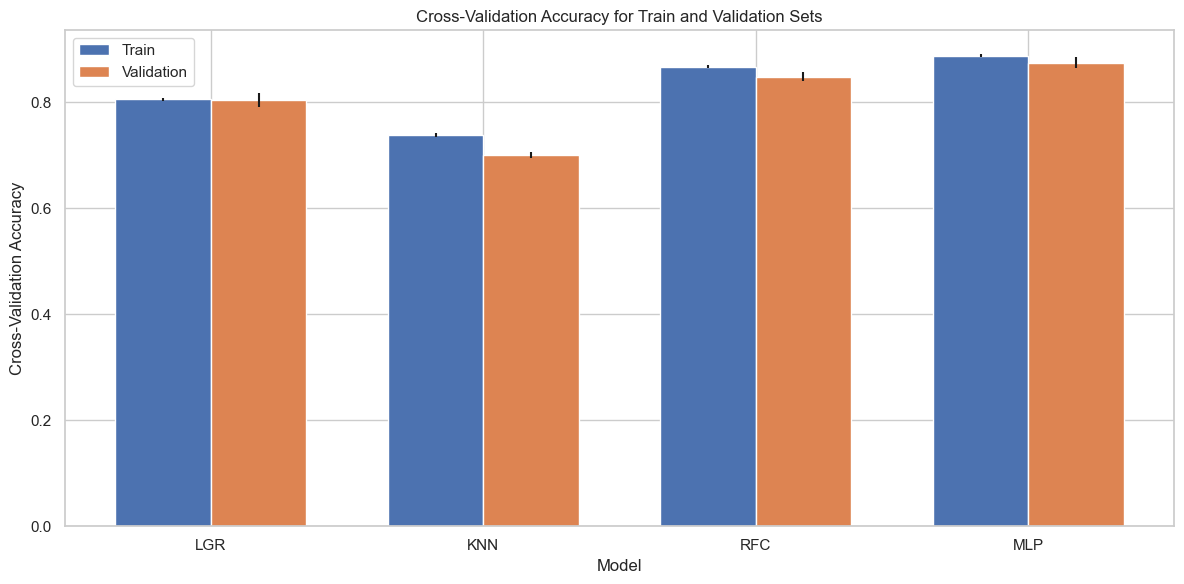

In [43]:

mean_train = result_train.mean()
std_train = result_train.std()
mean_val = result_valid.mean()
std_val = result_valid.std()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(len(mean_train))
bar_width = 0.35

bar_train = plt.bar(index, mean_train, bar_width, yerr=std_train, label='Train')
bar_val = plt.bar(index + bar_width, mean_val, bar_width, yerr=std_val, label='Validation')

plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy for Train and Validation Sets')
plt.xticks(index + bar_width / 2, [name for name, _ in classifiers])
plt.legend()

plt.tight_layout()
plt.show()

As we can see those are the train and validation auc of the four modles we chose to check for our modle. without any tunning of the hiper parmaters we got auc between 0.7-0.8 that are not very accurate but already better than a dummy modle who says only no (auc of 0.53 like we showed earlier)

## Setting Hyperparameter:

In [44]:

search_params = {
    'KNN': {'KNN__n_neighbors': [14],
            'KNN__metric': ['manhattan']},
    'RFC': {'RFC__n_estimators' :[200],
            'RFC__criterion':['entropy'],
            'RFC__min_samples_split' : [5],
            'RFC__min_samples_leaf': [6],
            'RFC__max_depth':[50]},
    'MLP': {'MLP__hidden_layer_sizes': [ (25,10,2)],
           'MLP__activation': ['relu'],
           'MLP__solver': ['adam'],
           'MLP__alpha': [0.05]},
    'LGR' : {'LGR__penalty': ['l2'],
            'LGR__C': [100],
            'LGR__solver': ['liblinear']}
             }


def set_hyper(t_data, la_data, classifiers):
    param = {}
    classifiers_opt = []
    k_fold_best_auc = pd.DataFrame(index=[0], columns=[name for name, _ in classifiers])
    for model_name, model in tqdm(classifiers):
        param_grid = search_params[model_name]
        grid = GridSearchCV(model, param_grid=param_grid,scoring='roc_auc',n_jobs=-1)
        grid_result = grid.fit(t_data, la_data)
        opt_model = model.set_params(**grid_result.best_params_)
        classifiers_opt.append((model_name, opt_model))
        k_fold_best_auc.loc[0,model_name] = grid_result.best_score_
        param[model_name] = grid_result.best_params_
    return param, classifiers_opt,k_fold_best_auc


best_perm, classifiers_opt,k_fold_best_auc = set_hyper(train_data_norm_full, train_data_labels_norm_full, classifiers)
%store classifiers_opt
%store best_perm
%store k_fold_best_auc
best_perm


  0%|          | 0/4 [00:00<?, ?it/s]


AttributeError: module 'os' has no attribute 'statvfs'

In [ ]:

print("Tuned modle validation means:\n", k_fold_best_auc,"\nBasic modle validation means:\n", result_valid.mean())


Tuned modle validation means:
         LGR       KNN      RFC       MLP
0  0.894393  0.866289  0.95327  0.966264 
Basic modle validation means:
 LGR    0.804567
KNN    0.701442
RFC    0.847356
MLP    0.874399
dtype: float64


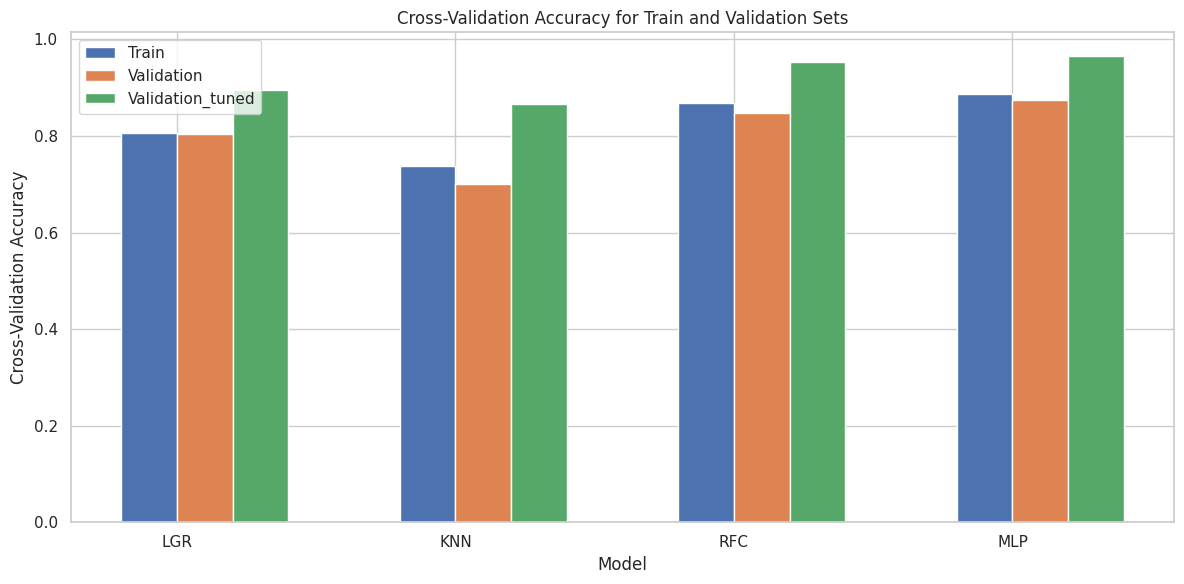

In [ ]:

mean_val_tuned_gridi = k_fold_best_auc.iloc[0,:]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(len(mean_train))
bar_width = 0.2

bar_train = plt.bar(index, mean_train, bar_width, label='Train')
bar_val = plt.bar(index + bar_width, mean_val, bar_width, label='Validation')
bar_val_tuned = plt.bar(index + 2*bar_width, mean_val_tuned_gridi, bar_width, label='Validation_tuned')

plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy for Train and Validation Sets')
plt.xticks(index + bar_width / 2, [name for name, _ in classifiers])
plt.legend()

plt.tight_layout()
plt.show()


## Features Evoluating:

we'll see the importance of each feature according to the RFM. 

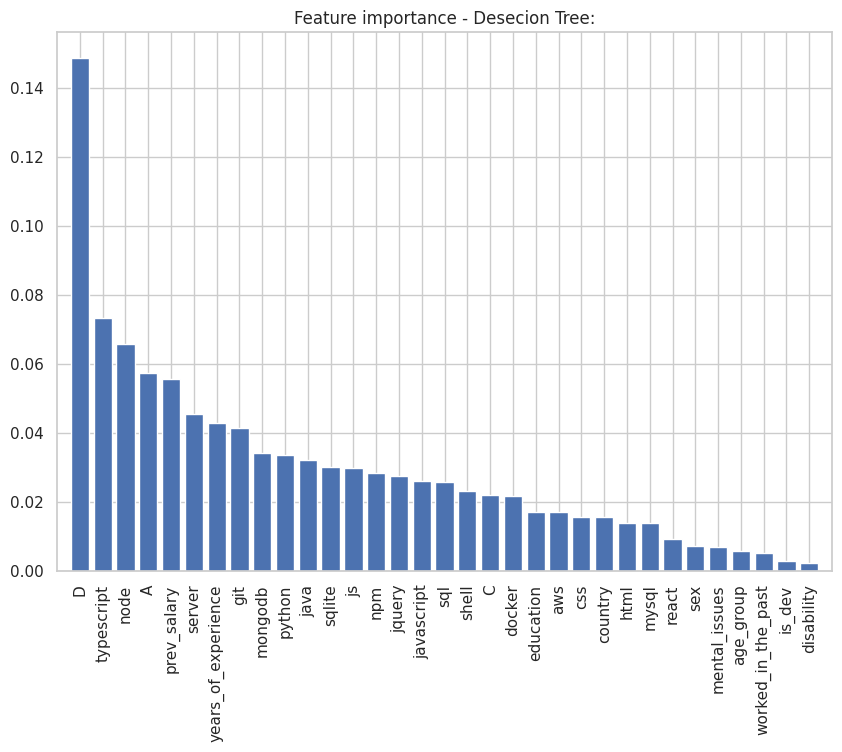

In [ ]:
rf_model = classifiers_opt[2][1].named_steps['RFC']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,7))
plt.title('Feature importance - Desecion Tree:')
plt.bar(range(train_data_norm.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(train_data_norm.shape[1]), train_data_norm.columns[indices], rotation='vertical')
plt.xlim([-1, train_data_norm.shape[1]])
plt.show()

**Checking the data set after pca on our modle**

In [ ]:
'''
RFC_pca = classifiers_opt[2][1].named_steps['RFC']
RFC_pca = RFC_pca.fit(train_data_norm_pca,train_data_labels_norm)
valid_data_norm_pca = pca.fit_transform(validation_data_norm)
y_pred_pca = RFC_pca.predict(valid_data_norm_pca)
y_pred_pca =y_pred_pca.reshape(-1,1)
print(f'The auc of the RFC modle after using pca is :{accuracy_score(y_pred_pca,validation_labels_norm):.2f}')
'''


"\nRFC_pca = classifiers_opt[2][1].named_steps['RFC']\nRFC_pca = RFC_pca.fit(train_data_norm_pca,train_data_labels_norm)\nvalid_data_norm_pca = pca.fit_transform(validation_data_norm)\ny_pred_pca = RFC_pca.predict(valid_data_norm_pca)\ny_pred_pca =y_pred_pca.reshape(-1,1)\nprint(f'The auc of the RFC modle after using pca is :{accuracy_score(y_pred_pca,validation_labels_norm):.2f}')\n"

# Part 4: 
## Evaluating the Models


**Confusion Matrices for RFC :**

confuison matrix :
 the accurcacy 0.8727163461538462


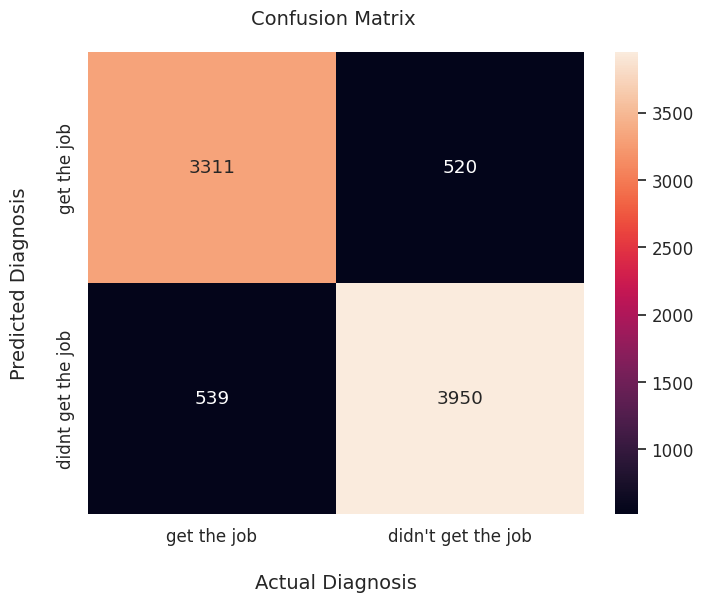

In [ ]:
clf_RFC= RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=50, min_samples_leaf=6, min_samples_split=5, random_state=42)
clf_RFC.fit(train_data_norm, train_data_labels_norm)
pred=clf_RFC.predict(validation_data_norm)
cm=confusion_matrix(validation_labels_norm, pred)
tn, fp, fn, tp = cm.ravel()
cm_arr = np.array([[tp,fp],[fn,tn]])
print(f'confuison matrix :\n the accurcacy {(cm[0, 0] + cm[1, 1]) / np.sum(cm)}' )
plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(cm, annot=True, fmt='d', )
ax.set_xlabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['get the job', 'didn\'t get the job'])
ax.set_ylabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['get the job', 'didnt get the job'])
ax.set_title("Confusion Matrix ", fontsize=14, pad=20)
plt.show()

True Positive (TP): 3311 - The model correctly predicted that the candidates got the job.

False Positive (FP): 520 - The model incorrectly predicted that the candidates got the job, but in fact they did not.

False Negative (FN): 539 - The model incorrectly predicted that the candidates didn't get the job, but in fact they did.

True Negative (TN): 3950 - The model correctly predicted that the candidates didn't get the job.

As we can see our modle is getting FN and FP at almost same amount what says that it probably mistaking by outliers in the dataframe. we can conclude that it has no bias in his predicated values and the modle is balanced.

In [ ]:
def KfoldPlot(X, y, clf, k):

    plt.figure(figsize=(10,10))
    kf = KFold(n_splits=k, shuffle=False)
    mean_tpr = np.zeros(100)
    mean_fpr = np.linspace(0, 1, 100)
    i=1
    for train_index, validation_index in kf.split(X):
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
        model = clf.fit(X_train, y_train)
        prob_prediction = model.predict_proba(X_validation)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_validation, prob_prediction)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        plt.plot(fpr, tpr, color='#D3D3D3')
        i+=1

    plt.plot([0], [0], color='#D3D3D3', linestyle='-', label='K-folds')

    mean_tpr /= k
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    #plot the random-guess line
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

    #And we plot the mean roc, the red line should be in the middle of all gray lines.
    plt.plot(mean_fpr, mean_tpr, color='red', linestyle='-', label='Mean ROC (area = %0.3f)' % mean_auc)
    #Setting some boundaries and adding a legend
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.legend(loc="lower right")

In [ ]:
LGR_ROC = Pipeline([('scaler', StandardScaler()),
                     ('LGR', LogisticRegression())])

KNN_ROC = Pipeline([('scaler', StandardScaler()),
                     ('KNN', KNeighborsClassifier(algorithm='brute'))])

RFC_ROC = Pipeline([('RFC', RandomForestClassifier())])

MLP_ROC = Pipeline([('MLP', MLPClassifier())])

classifiers_ROC = [
    ('LGR', LGR_ROC),
    ('KNN', KNN_ROC),
    ('RFC', RFC_ROC),
    ('MLP', MLP_ROC)
    ]

In [ ]:
for name, clf in classifiers_ROC:
  if name in best_perm:
    clf.set_params(**best_perm[name])

  0%|          | 0/4 [00:00<?, ?it/s]

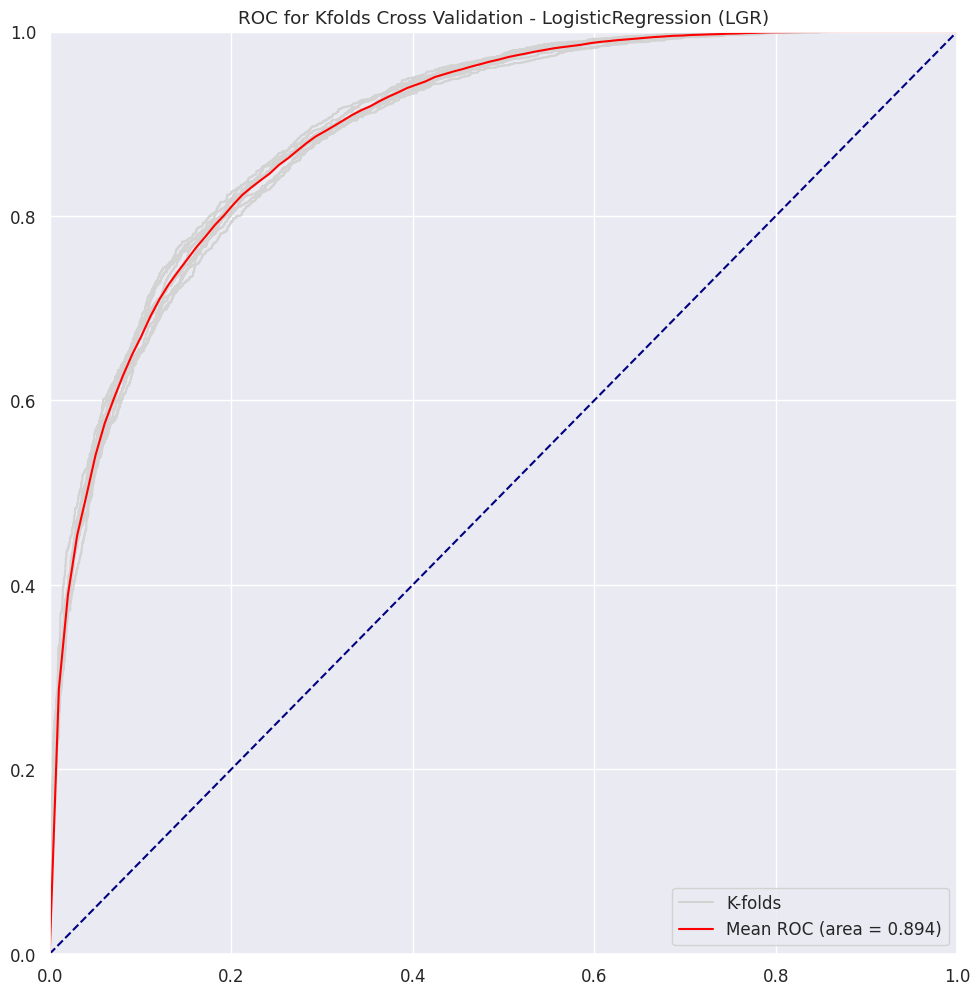

 25%|██▌       | 1/4 [00:05<00:17,  5.96s/it]

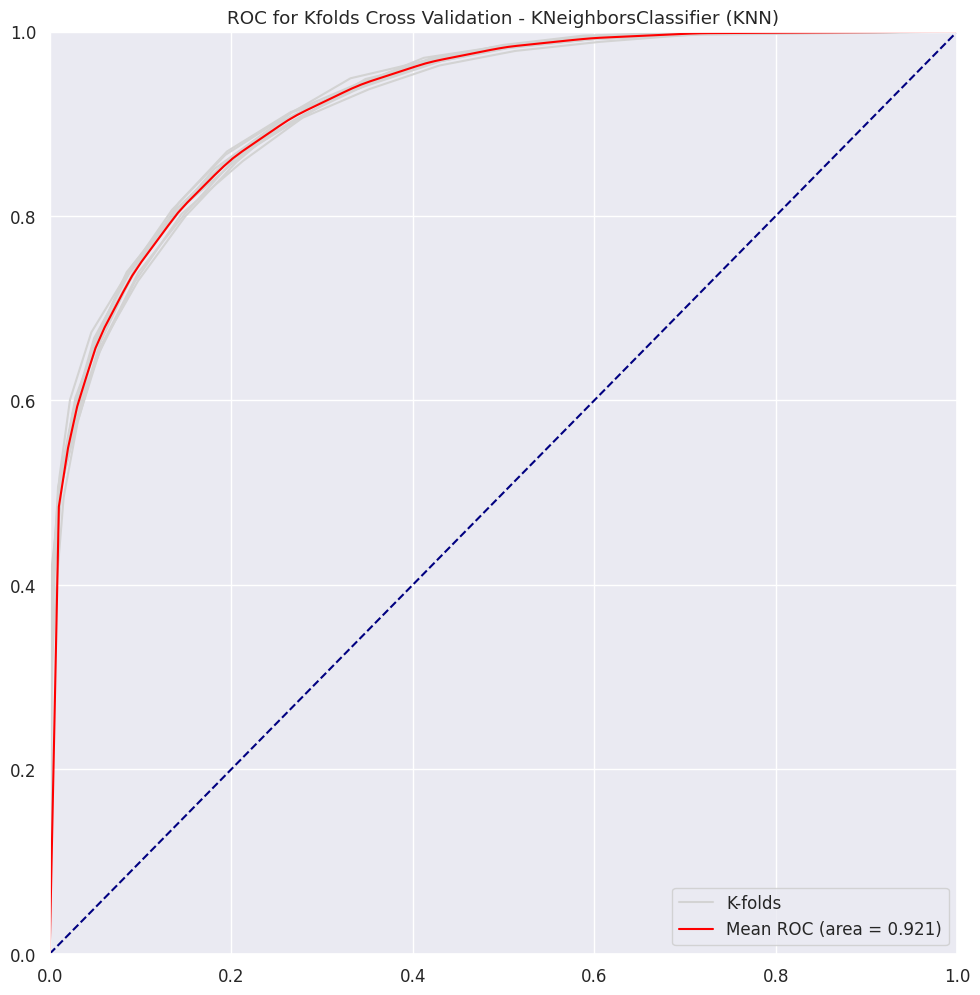

 50%|█████     | 2/4 [00:28<00:31, 15.99s/it]

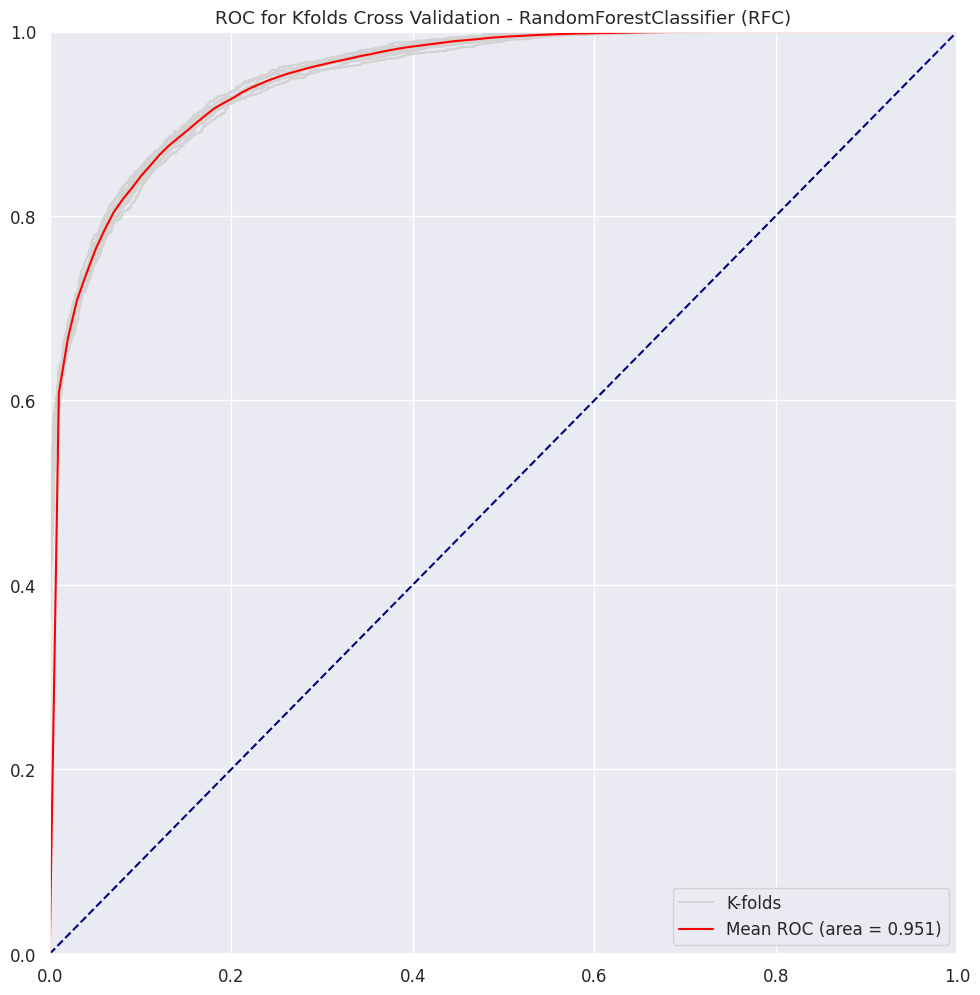

 75%|███████▌  | 3/4 [03:35<01:34, 94.04s/it]/home/eladshneor/miniconda3/envs/machine/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


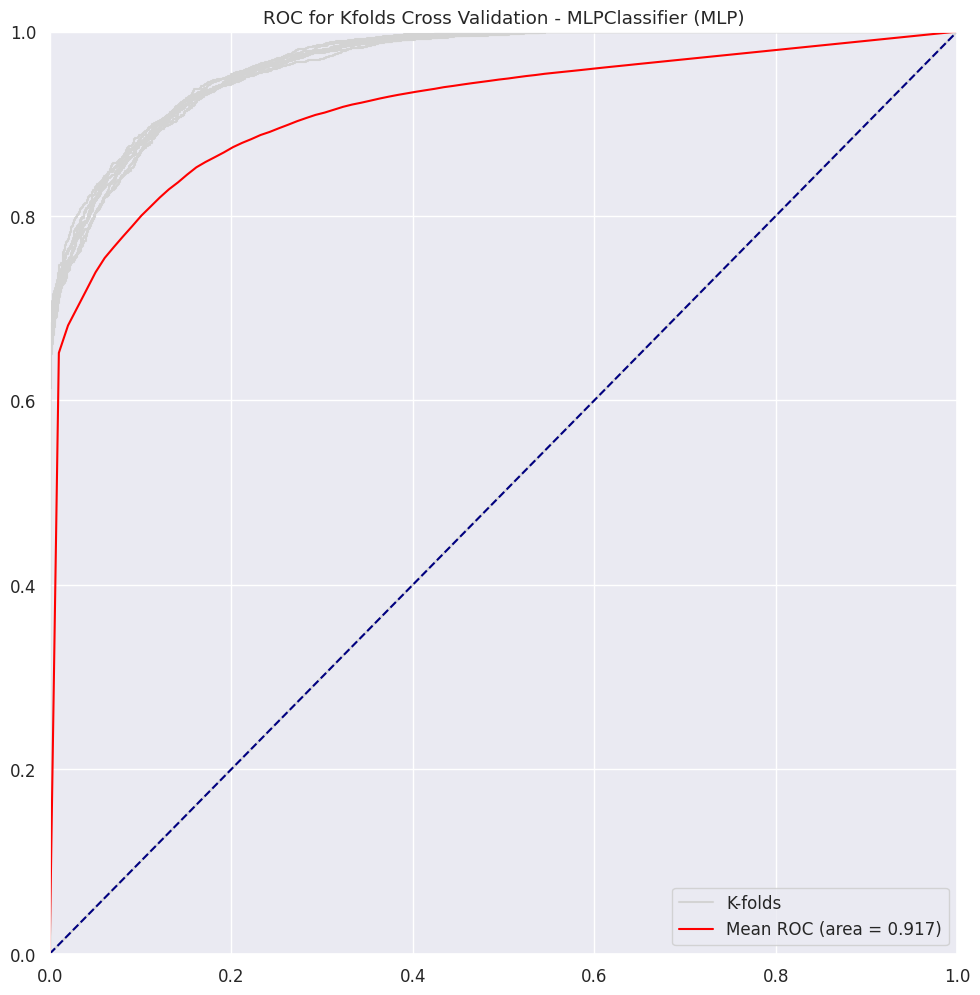

100%|██████████| 4/4 [07:01<00:00, 105.37s/it]


In [ ]:
# Plot roc curves for every classifier
for name, clf in tqdm(classifiers_ROC):
    full_name = type(clf[name]).__name__
    KfoldPlot(train_data_norm_full, train_data_labels_norm_full, clf, k=10)
    plt.tight_layout()
    plt.title('ROC for Kfolds Cross Validation - {} ({})'.format(full_name, name))
    plt.show()

We can see from the MLP modle ROC curve that although he showed after GridiSearch method the highest auc after doing k-fold for 10 diffrent validation we can see that the modle indeed at Overfitting phase. we can see clearly that on some validation sets he get bad auc causing the mean getting under 0.9.

## Overfit checking : 

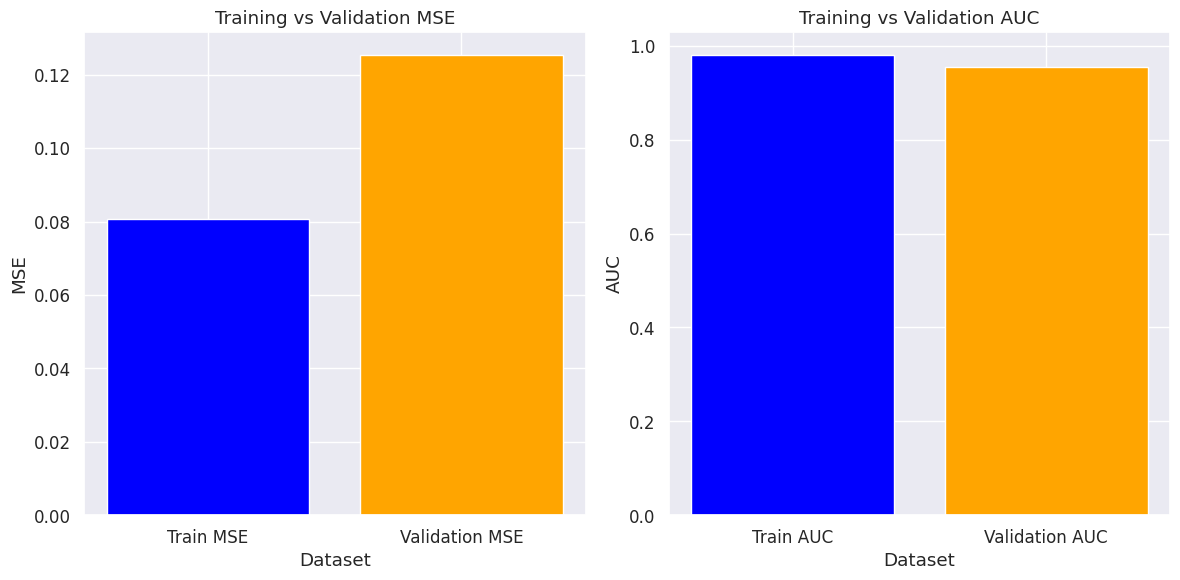

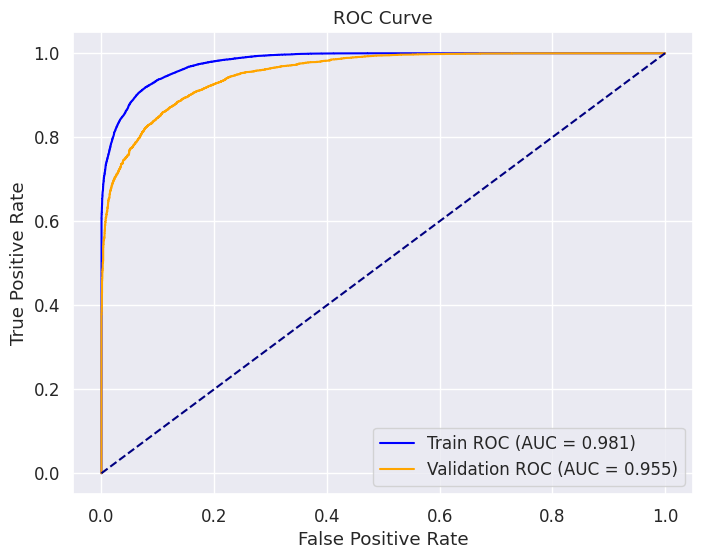

In [ ]:

RFC = classifiers_opt[2][1]
# Fit the model
RFC.fit(train_data_norm, train_data_labels_norm)

# Predictions
y_train_pred = RFC.predict(train_data_norm)
y_valid_pred = RFC.predict(validation_data_norm)

# Probabilities for AUC
y_train_pred_prob = RFC.predict_proba(train_data_norm)[:, 1]
y_valid_pred_prob = RFC.predict_proba(validation_data_norm)[:, 1]

# Calculate MSE
train_mse = mean_squared_error(train_data_labels_norm, y_train_pred)
valid_mse = mean_squared_error(validation_labels_norm, y_valid_pred)

# Calculate AUC
train_auc = roc_auc_score(train_data_labels_norm, y_train_pred_prob)
valid_auc = roc_auc_score(validation_labels_norm, y_valid_pred_prob)

# Plotting MSE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(['Train MSE', 'Validation MSE'], [train_mse, valid_mse], color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('MSE')
plt.title('Training vs Validation MSE')

# Plotting AUC
plt.subplot(1, 2, 2)
plt.bar(['Train AUC', 'Validation AUC'], [train_auc, valid_auc], color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')

plt.tight_layout()
plt.show()

# Plotting ROC Curves
fpr_train, tpr_train, _ = roc_curve(train_data_labels_norm, y_train_pred_prob)
fpr_valid, tpr_valid, _ = roc_curve(validation_labels_norm, y_valid_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC (AUC = {train_auc:.3f})')
plt.plot(fpr_valid, tpr_valid, color='orange', label=f'Validation ROC (AUC = {valid_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

AS you can see those are the differences that exist in our modle between train and validation.

 In order to deal with overfitting you can do sevral methods. one of them is tunning the parameters of the model. After choosing the optimal parameters using the GridiSearch method, we surtenly got the best validation auc that the modle can get. that means that there is no option for the Gridi giving us a paramters that causing overfitting where it'll cause to get a worse validation auc. 
 As we said before we didn't find that our modle is with too much features and because of that we conclude that our modle is'nt in overfitting. 

# **Part 5:** 

the chosen modle is RFC

In [ ]:
RFC = classifiers_opt[2][1]
print(f"The chosen modle is RFC with validation AUC : {round(k_fold_best_auc.loc[0,'RFC'],3)}")

The chosen modle is RFC with validation AUC : 0.953


In [ ]:

sub_pipe = Pipeline([
    ('pre', process_pipe),
    ('clf', RFC)
])

def postprocessor(df, test):
    df['job_proba'] = df.iloc[:,1]
    df['ID'] = test['ID']
    df = df[['ID', 'job_proba']]
    return df

In [ ]:
test_data = pd.read_csv("test.csv")

In [ ]:
test_data_id = test_data['ID']
test_data = test_data.drop('ID',axis=1)
test_data_prob = sub_pipe.predict_proba(test_data)
test_data_prob = pd.DataFrame(test_data_prob)
test_data_prob['ID']=test_data_id
test_data['ID']=test_data_id
final_data = postprocessor(test_data_prob, test_data)

/tmp/ipykernel_662877/2247985442.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data["age_group"]=train_data["age_group"].replace({"young":0,"old":1})
/tmp/ipykernel_662877/2247985442.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data["disability"] = train_data["disability"].replace({"No":0,"Yes":1})
/tmp/ipykernel_662877/2247985442.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(co

In [ ]:
final_data.set_index('ID', inplace=True)
final_data.index.name = None

In [ ]:
print(final_data.shape)
final_data.head(10)

(18000, 1)


,job_proba
48786,0.729944
53074,0.138919
11758,0.759846
49289,1.000000
56787,0.568774
27135,0.126209
1222,0.026609
45631,0.365981
29686,0.218729
71663,0.966521


In [ ]:
final_data.to_csv('results_group_36.csv')